## Clustering Premenopausal Users with Irregular Cycles (*No VMS)

In [67]:
import pandas as pd
import numpy as np
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy as scipy
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import utils

In [68]:
from sensorfabric.athena import athena

In [69]:
# Establish connection with the database using PyAthena.
cursor = connect(s3_staging_dir='s3://menolife-opensci/athena/',
                  schema_name='menolife',
                  cursor_class=PandasCursor,
                  work_group='amyris',
                  region_name='us-east-1'
                ).cursor()

In [70]:
%set_env AWS_PROFILE=opensci

env: AWS_PROFILE=opensci


In [71]:
db = athena(database='menolife', workgroup='amyris', offlineCache=True)

## Dataset creation

In [72]:
# Get all the symptoms.
symptoms = db.execQuery("select distinct(name) name from symptoms order by name asc", cached=True)
print(symptoms.shape)

(45, 1)


In [73]:
# Create an empty list for all the columns which are going to be the individual symptoms.
symptoms = symptoms['name'].values

## Checking the actual onboarding responses to a simpler version of the query

In [74]:


premenopausalusers_symptoms_query = """

WITH query1 AS (

    SELECT DISTINCT healthid
    FROM onboardingpp o
    WHERE (questions = 'How would you describe your periods?')
        AND length(answers) > 0
        AND answers NOT LIKE '%have a period anymore%'
        AND answers NOT LIKE '%take birth control%'
),

query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptompp_npt s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        and symptoms_recorded>10
        and symptoms_recorded<300
        AND ss.uid IN (SELECT DISTINCT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)

SELECT q2.uid, o.questions, o.answers
FROM query2 q2
INNER JOIN onboardingpp o ON q2.uid = o.healthid
ORDER BY q2.uid, o.questions, q2.count DESC;

   

"""

premenopausalusers_symptoms = db.execQuery(premenopausalusers_symptoms_query, cached=True)
print(premenopausalusers_symptoms.shape)



(139829, 3)


## Ultrasimple Premenopause Query - Seems to filter out all menopausal answers. Still includes people with hot flashes which I will filter out later. This should be the "truest" premenopausal set. Then we'll filter for irregular cyclers who have no hotflashes as our premenopausal irregular cohort


In [75]:

premenopausalusers_symptoms_query = """

WITH query1 AS (

    SELECT DISTINCT healthid
    FROM onboardingpp o
    WHERE (questions = 'How would you describe your periods?')
        AND length(answers) > 0
        AND answers NOT LIKE '%have a period anymore%'
        AND answers NOT LIKE '%take birth control%'
),

query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptompp_npt s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        and symptoms_recorded >10
        and symptoms_recorded<300
       
        AND ss.uid IN (SELECT DISTINCT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)

SELECT q2.uid, q2.name, q2.count
FROM query2 q2
ORDER BY q2.uid, q2.count DESC;
"""

premenopausalusers_symptoms = db.execQuery(premenopausalusers_symptoms_query, cached=True)
print(premenopausalusers_symptoms.shape)

(40664, 3)


In [76]:
premenopausalusers_symptoms.head()

uid          name  count
0  5f98bab244eca8ead4eca209      dry_eyes      4
1  5f98bab244eca8ead4eca209      spotting      3
2  5f98bab244eca8ead4eca209     brain_fog      2
3  5f98bab244eca8ead4eca209  memory_lapse      1
4  5f98bab244eca8ead4eca209        nausea      1

In [77]:
#Is this still keeping only the correct uids? 

# Calculate the unique number of UIDs
unique_uids_count = len(premenopausalusers_symptoms['uid'].unique())

# Display the unique number of UIDs
print("Unique number of UIDs:", unique_uids_count)

Unique number of UIDs: 3052


In [78]:
frame = pd.DataFrame()  # Empty dataframe that will contain all the dataset.
uidmap = {}
# Start breaking the users frame and extract data from it to add to the data matrix.
temp = None  # Temp dictionary that holds the symptom counts for each user.
for uid, sname, scount in zip(premenopausalusers_symptoms['uid'].values, premenopausalusers_symptoms['name'].values, premenopausalusers_symptoms['count'].values):
    if not (uid in uidmap):
        # If temp is not None (everything except for the first uid then we will concat the last uid to the frame.
        if not (temp is None):
            temp = pd.Series(temp)
            temp = temp.to_frame().T
            frame = pd.concat([frame, temp], ignore_index=True)
        temp = {}  # Start fresh again.
        temp['uid'] = uid
        uidmap[uid] = 1
    temp[sname] = scount
frame = frame.set_index(['uid']) # Set the 'uid' as the index, so it becomes easier to query.
frame = frame.fillna(0)


In [79]:
frame=frame.astype(int)

## Diving a bit deeper into who is reporting hot flashes or night sweats in this group. (shravan pet project)

?Shravan - How many people who we classified as pre-menopausal also report classic memopause symptoms like hot-flashes and night sweats.

In [16]:
special = frame[(frame['hot_flashes'] > 0) | (frame['night_sweats'] > 0)]

In [ ]:
print(special.shape)
print(frame.shape)
print(special.shape[0]/frame.shape[0])

(2437, 45)
(3775, 45)
0.6455629139072848


~64% of the user who have been classified in the pre-menopause group report having hot flashes or night sweats.

There are 2,437 users 

In [ ]:
# Calculate the total count of each symptom type (sum across columns)
symptom_totals = special.sum(axis=0)

# Calculate the total count of all symptoms
total_symptom_count = symptom_totals.sum()

# Calculate the percentage of each symptom type's count relative to the total count of all symptoms
symptom_percentages = (symptom_totals / total_symptom_count) * 100

# Sort the symptom_percentages in descending order (most frequent to least frequent)
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

# Print out each symptom type and its corresponding percentage in the sorted order
c = 0
for symptom, count in zip(symptom_percentages_sorted.index, symptom_percentages_sorted.values):
    c += 1
    print(f"{symptom}: {count:.2f}%")
    if c > 100:
        break

hot_flashes: 12.12%
fatigue: 6.44%
headaches: 4.97%
bloating: 4.39%
cramps: 4.35%
anxiety: 4.16%
joint_pain: 4.04%
night_sweats: 3.86%
allergies: 3.81%
dry_skin: 3.41%
muscle_tension: 2.88%
insomnia: 2.83%
brain_fog: 2.77%
dry_eyes: 2.65%
mood_swings: 2.51%
breast_pain: 2.45%
spotting: 2.44%
brittle_nails: 2.43%
depression: 2.20%
itchy_skin: 2.11%
ringing_ears: 1.78%
chills: 1.65%
dizzy: 1.58%
sex_drive: 1.42%
nausea: 1.41%
constipation: 1.35%
facial_hair: 1.34%
diarrhea: 1.34%
tingling_extremeties: 1.34%
incontinence: 1.18%
hair_loss: 1.12%
irregular_beat: 1.11%
heartburn: 1.03%
memory_lapse: 1.03%
breast_swelling: 0.98%
odor: 0.98%
vaginal_dryness: 0.72%
ovulation_pain: 0.49%
vertigo: 0.38%
ovulation: 0.22%
vomiting: 0.20%
yeast_infection: 0.18%
painful_intercourse: 0.16%
uti: 0.14%
nipple_discharge: 0.06%


# Define symptom breakdown by the (period = unpredictable, period = regular)

### Unpredictable with No VMS is the Cohort We are Looking For

In [80]:
import utils
unpredictable_uids = db.execQuery('select uid from premeno_period_unpredictable', cached=True) #ok i guess we had a table called that already...convenient

In [81]:
unpredictable = frame[frame.index.isin(unpredictable_uids['uid'].values)]

In [82]:
unpredictablenovms=unpredictable[(unpredictable['hot_flashes'] == 0) & (unpredictable['night_sweats'] == 0)]

In [21]:
#utils.symPercentages(unpredictable)

In [22]:
#unpredictablewvms = special[special.index.isin(unpredictable_uids['uid'].values)]

NameError: name 'special' is not defined

In [26]:
#utils.symPercentages(unpredictablewvms)

NameError: name 'unpredictablewvms' is not defined

## Regular no vms and Regular w/ vms

In [17]:
regular_uids = db.execQuery('select uid from premeno_period_regular', cached=True)
regular = frame[frame.index.isin(regular_uids['uid'].values)]
utils.symPercentages(regular)

fatigue: 6.71%
bloating: 6.10%
cramps: 5.65%
headaches: 5.55%
hot_flashes: 4.23%
anxiety: 4.13%
allergies: 3.83%
joint_pain: 3.83%
breast_pain: 3.54%
dry_skin: 3.38%
dry_eyes: 3.36%
brain_fog: 3.36%
spotting: 3.16%
muscle_tension: 2.84%
night_sweats: 2.69%
mood_swings: 2.56%
insomnia: 2.45%
brittle_nails: 2.32%
ringing_ears: 2.20%
depression: 2.02%
itchy_skin: 1.99%
sex_drive: 1.76%
constipation: 1.68%
dizzy: 1.67%
breast_swelling: 1.67%
diarrhea: 1.56%
hair_loss: 1.47%
nausea: 1.44%
facial_hair: 1.44%
irregular_beat: 1.39%
tingling_extremeties: 1.29%
incontinence: 1.27%
chills: 1.19%
odor: 1.18%
memory_lapse: 1.03%
heartburn: 0.99%
vaginal_dryness: 0.81%
ovulation_pain: 0.60%
vertigo: 0.46%
ovulation: 0.45%
yeast_infection: 0.22%
painful_intercourse: 0.19%
vomiting: 0.17%
uti: 0.13%
nipple_discharge: 0.05%


In [19]:
regularnovms=regular[(regular['hot_flashes'] == 0) & (regular['night_sweats'] == 0)]

In [20]:
regularwvms=regular[(regular['hot_flashes'] > 0) | (regular['night_sweats'] > 0)]

## So now we have 3 groups we care about here

### all women who are not menopausal, all women who are additionally regular and display no hot flashes, and women who are not menopausal but irregular and DO have hot flasehs

#frame is all premeno (if not runing the line below to remove HFs);unpredictablewvms = putative perimenopausal; regularnovms. we also have unpredictable

In [22]:
#Let's Identify the number of UIDs in each group

#Now how many do I have who are unpredictable with VMS
unique_uids = regularnovms.index.unique().tolist()
unique_uids_size = len(unique_uids)
print("Size of Regular with No Vasomotor Symptoms:", unique_uids_size)


Size of Regular with No Vasomotor Symptoms: 468


In [37]:
#Now how many do I have who are Regular with VMS
unique_uids = regularwvms.index.unique().tolist()
unique_uids_size = len(unique_uids)
print("Size of Regular With Vasomotor Symptoms:", unique_uids_size)

Size of Regular With Vasomotor Symptoms: 685


# Move on Back to Rest of the Analyses....

In [83]:
#Now how many do I have left?

unique_uids = unpredictablenovms.index.unique().tolist()
unique_uids_size = len(unique_uids)
print("Size of unique_uids:", unique_uids_size)

Size of unique_uids: 738


In [28]:
unpredictablenovms.to_csv('premenopausalsymptoms_unpredictablenovms_npt_correct.csv')

In [84]:
unpredictablenovms.head()

dry_eyes  spotting  brain_fog  memory_lapse  nausea  \
uid                                                                             
5f98bab244eca8ead4eca209         4         3          2             1       1   
5f9b22b7d01db71874617a55         1         9          5             0       3   
5fec91a88c7e61fc62131b1c         0         0          0             0       0   
6022a6fdbea29a1eb66b6fe0         1         0          0             0       0   
60ab0ca1bea29a1eb66c61a0         1         0          1             0       0   

                          dry_skin  vertigo  anxiety  bloating  chills  ...  \
uid                                                                     ...   
5f98bab244eca8ead4eca209         1        1        1         1       1  ...   
5f9b22b7d01db71874617a55         0        0        0         1       0  ...   
5fec91a88c7e61fc62131b1c         1        0        4         0       0  ...   
6022a6fdbea29a1eb66b6fe0         0        1        4         0       0  ...   
60ab0ca1bea29a1eb66c61a0         0        0        1         0       0  ...   

                          vaginal_dryness  itchy_skin  ovulation_pain  \
uid                                                                     
5f98bab244eca8ead4eca209                0           0               0   
5f9b22b7d01db71874617a55                0           0               0   
5fec91a88c7e61fc62131b1c                0           0               0   
6022a6fdbea29a1eb66b6fe0                0           0               0   
60ab0ca1bea29a1eb66c61a0                0           1               0   

                          ovulation  odor  uti  nipple_discharge  \
uid                                                                
5f98bab244eca8ead4eca209          0     0    0                 0   
5f9b22b7d01db71874617a55          0     0    0                 0   
5fec91a88c7e61fc62131b1c          0     0    0                 0   
6022a6fdbea29a1eb66b6fe0          0     0    0                 0   
60ab0ca1bea29a1eb66c61a0          0     1    0                 0   

                          yeast_infection  painful_intercourse  vomiting  
uid                                                                       
5f98bab244eca8ead4eca209                0                    0         0  
5f9b22b7d01db71874617a55                0                    0         0  
5fec91a88c7e61fc62131b1c                0                    0         0  
6022a6fdbea29a1eb66b6fe0                0                    0         0  
60ab0ca1bea29a1eb66c61a0                0                    0         0  

[5 rows x 45 columns]

In [85]:
unpredictablenovms.shape

(738, 45)

In [86]:
data_type = unpredictablenovms[symptoms].dtypes
#print(data_type)

## Create One Hot Encoding for Network Analysis

In [87]:
encoding = unpredictablenovms.copy(deep=True)
def replace_map(x):
    if x > 0:
        return 1
    else:
        return 0
encoding = encoding.applymap(replace_map)

encoding.to_csv('symptoms_premenopause_unpredictablenovms_npt_onehot.csv', index=False)

## What's the distribution of symptoms by UID, and total Number of symptoms?

In [88]:
total_symptom_count_per_uid = unpredictablenovms.sum(axis=1)

# Overall sum of all symptom counts
overall_total_symptom_count = total_symptom_count_per_uid.sum()

#print("Total symptom count per UID:")
#print(total_symptom_count_per_uid)

print("\nOverall total symptom count:")
print(overall_total_symptom_count)


Overall total symptom count:
18046


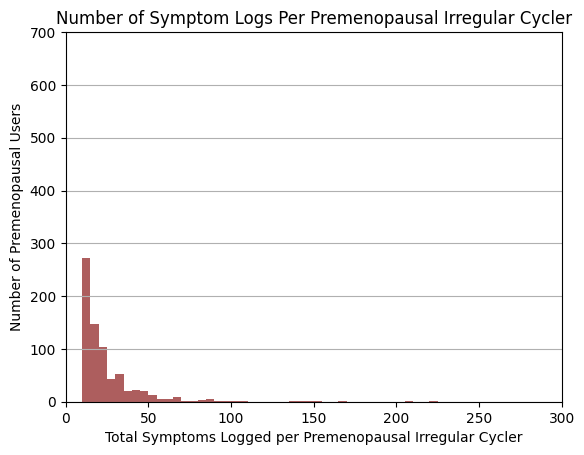

Median Symptoms per User: 17.0
Median Absolute Deviation (MAD) of Symptoms per User: 5.0


In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the 'frame' dataframe with symptom counts

# Total symptom count for each UID
total_symptom_count_per_uid = unpredictablenovms.sum(axis=1)

# Calculate the total symptoms per user
total_symptoms_per_user = total_symptom_count_per_uid.values

# Calculate the median and median absolute deviation
median_symptoms_per_user = np.median(total_symptoms_per_user)
mad_symptoms_per_user = np.median(np.abs(total_symptoms_per_user - median_symptoms_per_user))


# Create histogram with specified bins
bins = range(0, max(total_symptoms_per_user) + 5, 5)

plt.hist(total_symptoms_per_user, bins=bins, edgecolor='none', alpha=0.7,color=(139/255,26/255,26/255))
plt.xlabel('Total Symptoms Logged per Premenopausal Irregular Cycler')
plt.ylabel('Number of Premenopausal Users')
plt.title('Number of Symptom Logs Per Premenopausal Irregular Cycler')
plt.grid(axis='y')
plt.ylim(0,700) #note it goes up to about 2500
plt.xlim(0, 300) #note some rando users log >500 symptoms. Should we omit them?
plt.show()

print("Median Symptoms per User:", median_symptoms_per_user)
print("Median Absolute Deviation (MAD) of Symptoms per User:", mad_symptoms_per_user)


## Symptom Frequency by % of Total Symptoms, For Each Symptom

In [90]:
# Calculate the total count of each symptom type (sum across columns)
symptom_totals = unpredictablenovms.sum(axis=0)

# Calculate the total count of all symptoms
total_symptom_count = symptom_totals.sum()

# Calculate the percentage of each symptom type's count relative to the total count of all symptoms
symptom_percentages = (symptom_totals / total_symptom_count) * 100

# Sort the symptom_percentages in descending order (most frequent to least frequent)
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

# Print out each symptom type and its corresponding percentage in the sorted order
c = 0
for symptom, count in zip(symptom_percentages_sorted.index, symptom_percentages_sorted.values):
    c += 1
    print(f"{symptom}: {count:.2f}%")
    if c > 100:
        break

spotting: 8.44%
fatigue: 7.77%
cramps: 6.63%
bloating: 6.13%
headaches: 5.23%
anxiety: 5.17%
breast_pain: 4.21%
joint_pain: 3.95%
brain_fog: 3.61%
allergies: 3.31%
mood_swings: 3.27%
depression: 2.93%
muscle_tension: 2.75%
dry_skin: 2.67%
itchy_skin: 2.39%
dry_eyes: 2.16%
insomnia: 2.09%
hair_loss: 1.94%
dizzy: 1.83%
memory_lapse: 1.81%
sex_drive: 1.77%
constipation: 1.75%
brittle_nails: 1.72%
facial_hair: 1.65%
breast_swelling: 1.56%
ringing_ears: 1.45%
tingling_extremeties: 1.39%
diarrhea: 1.29%
nausea: 1.28%
incontinence: 1.10%
irregular_beat: 1.03%
heartburn: 0.85%
chills: 0.84%
odor: 0.83%
vaginal_dryness: 0.73%
ovulation_pain: 0.66%
vertigo: 0.56%
ovulation: 0.49%
uti: 0.24%
painful_intercourse: 0.18%
yeast_infection: 0.16%
vomiting: 0.13%
nipple_discharge: 0.06%
hot_flashes: 0.00%
night_sweats: 0.00%


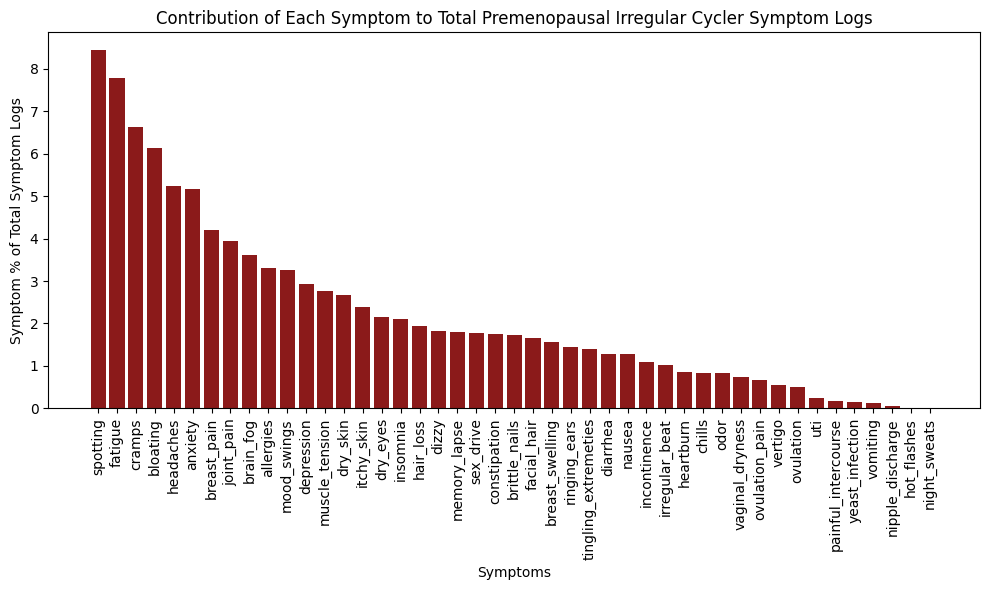

In [91]:
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.bar(symptom_percentages_sorted.index, symptom_percentages_sorted.values,color=(139/255,26/255,26/255))
plt.xlabel("Symptoms")
plt.ylabel("Symptom % of Total Symptom Logs")
plt.title("Contribution of Each Symptom to Total Premenopausal Irregular Cycler Symptom Logs")
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent cropping of labels
plt.show()

## Symptom Frequency by % of Users Reporting that Symptom

In [92]:
frame=unpredictablenovms

In [93]:
# Step 1: Calculate the total number of users
total_users = len(frame)

# Step 2: Calculate the percentage of users who have each symptom
symptom_percentages = (frame.astype(bool).sum() / total_users) * 100

print(symptom_percentages.sort_values(ascending=False))

fatigue                 75.474255
bloating                62.737127
cramps                  57.317073
anxiety                 52.710027
headaches               50.542005
brain_fog               46.883469
joint_pain              46.341463
mood_swings             41.463415
depression              37.127371
spotting                36.991870
breast_pain             36.449864
dry_skin                36.043360
allergies               34.688347
muscle_tension          34.146341
itchy_skin              32.655827
insomnia                29.539295
facial_hair             28.048780
dry_eyes                27.777778
hair_loss               27.235772
dizzy                   26.964770
memory_lapse            26.558266
brittle_nails           24.796748
sex_drive               24.254743
constipation            23.441734
tingling_extremeties    22.764228
diarrhea                19.918699
nausea                  19.512195
ringing_ears            17.615176
breast_swelling         17.344173
irregular_beat

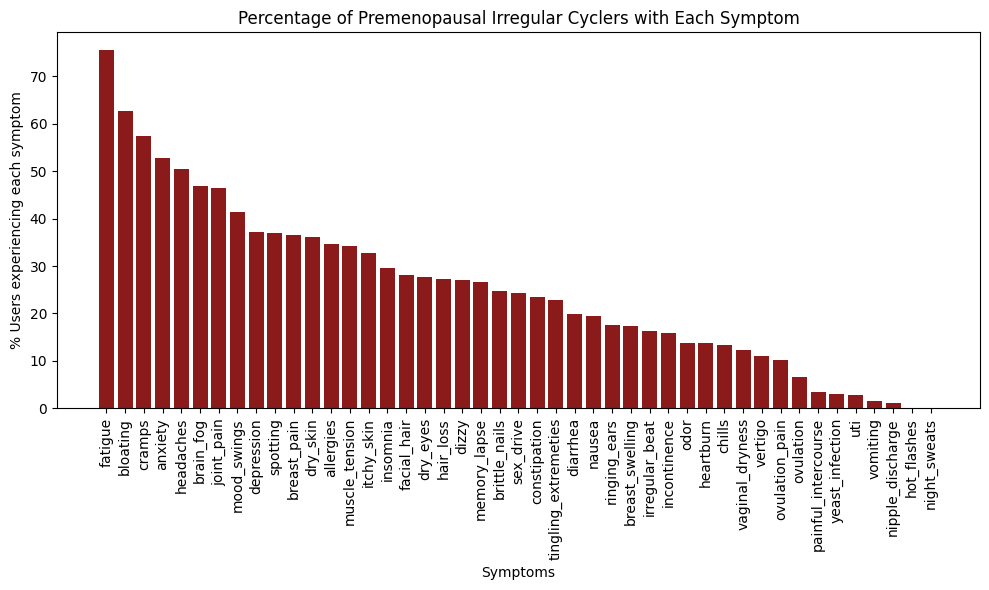

In [94]:
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.bar(symptom_percentages_sorted.index, symptom_percentages_sorted.values,color=(139/255,26/255,26/255))
plt.xlabel("Symptoms")
plt.ylabel("% Users experiencing each symptom")
plt.title("Percentage of Premenopausal Irregular Cyclers with Each Symptom")
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent cropping of labels
plt.show()

## Covariance matrix of the features

Standardize the features first.

In [96]:
data_type = frame[symptoms].dtypes
print(data_type)

sframe = frame[symptoms] #.astype('int64')


allergies               int64
anxiety                 int64
bloating                int64
brain_fog               int64
breast_pain             int64
breast_swelling         int64
brittle_nails           int64
chills                  int64
constipation            int64
cramps                  int64
depression              int64
diarrhea                int64
dizzy                   int64
dry_eyes                int64
dry_skin                int64
facial_hair             int64
fatigue                 int64
hair_loss               int64
headaches               int64
heartburn               int64
hot_flashes             int64
incontinence            int64
insomnia                int64
irregular_beat          int64
itchy_skin              int64
joint_pain              int64
memory_lapse            int64
mood_swings             int64
muscle_tension          int64
nausea                  int64
night_sweats            int64
nipple_discharge        int64
odor                    int64
ovulation 

In [97]:
sframe = frame[symptoms]#.astype('int64')
sframe = (sframe - sframe.mean()) / sframe.std()

## Visualizing the distribution of some of the syptoms

Hotflashes

/home/ubuntu/anaconda3/envs/menolife/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


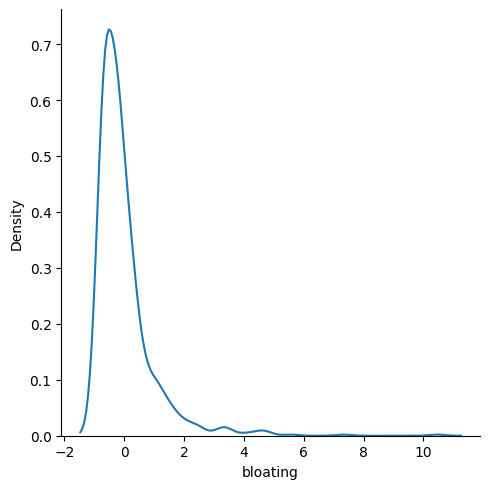

In [98]:
sns.displot(sframe, x='bloating', kind='kde')

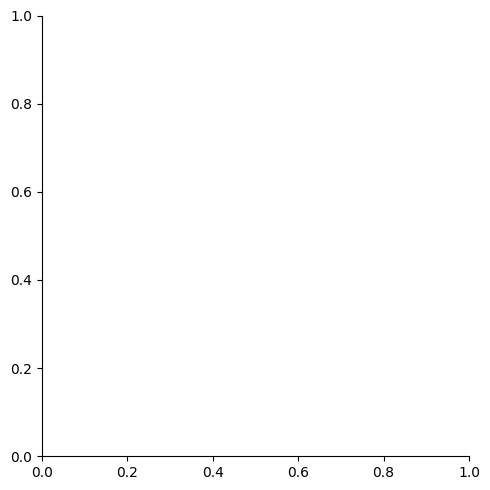

In [99]:
sns.displot(sframe, x='hot_flashes', kind='kde')

In [100]:
cmatrix = sframe.cov()

# List of symptom names to remove
symptoms_to_remove = ["hot_flashes", "night_sweats"]

# Step 1: Drop the specified rows and columns from the covariance matrix
cmatrix = cmatrix.drop(symptoms_to_remove, axis=0).drop(symptoms_to_remove, axis=1)

# Step 2: Print the filtered covariance matrix
#print(filtered_cmatrix)


In [101]:
cmatrix.to_csv('premeno_irregular_novms_npt_correct_symptom_covariance.csv', index=True)

In [103]:
fig = px.imshow(cmatrix, 
                width=2000, 
                height=1024, 
                text_auto=True, 
                aspect='auto',
                title='Symptom Covariance')
fig.show()
# Also go ahead and save this figure.
fig.write_image('premeno_irregularnovms_symptom_npt_covariance.png')

## Find pairs of symptoms with more than 80% corelation.

In [105]:
import pandas as pd
import plotly.express as px

th = 0.5

fmatrix = cmatrix[cmatrix >= th]

# create the heatmap with the updated 'fmatrix'
fig = px.imshow(fmatrix,
                width=1024,
                height=1024,
                text_auto=True,
                aspect='auto',
                title='Symptom Covariance')
fig.show()

# Create an empty list to store the results
covariance_results = []

indexes = fmatrix.index.values
for s in symptoms:
    if s not in ['hot_flashes', 'night_sweats']:  # Exclude 'hot_flashes' and 'night_sweats' from iteration
        paired = fmatrix[s].dropna().index.values
        # We can go ahead and calculate the covariance and store the results in the list.
        for p in paired:
            if not (s == p):
                covariance = fmatrix.loc[s][p]
                covariance_results.append({'Symptom1': s, 'Symptom2': p, 'Covariance': covariance})

# Convert the list to a DataFrame
covariance_results_df = pd.DataFrame(covariance_results)

# Sort the DataFrame by the 'Covariance' column in descending order
covariance_results_df = covariance_results_df.sort_values(by='Covariance', ascending=False)

# Print the sorted results
print(covariance_results_df)


        Symptom1       Symptom2  Covariance
5      ovulation            uti    0.618401
6            uti      ovulation    0.618401
1        anxiety       insomnia    0.558911
3       insomnia        anxiety    0.558911
4    mood_swings       vomiting    0.544340
7       vomiting    mood_swings    0.544340
0        anxiety  brittle_nails    0.502317
2  brittle_nails        anxiety    0.502317


### Notes

With super users filtered out -- there are MUCH weaker pairwise correlations.

## Cluster Map

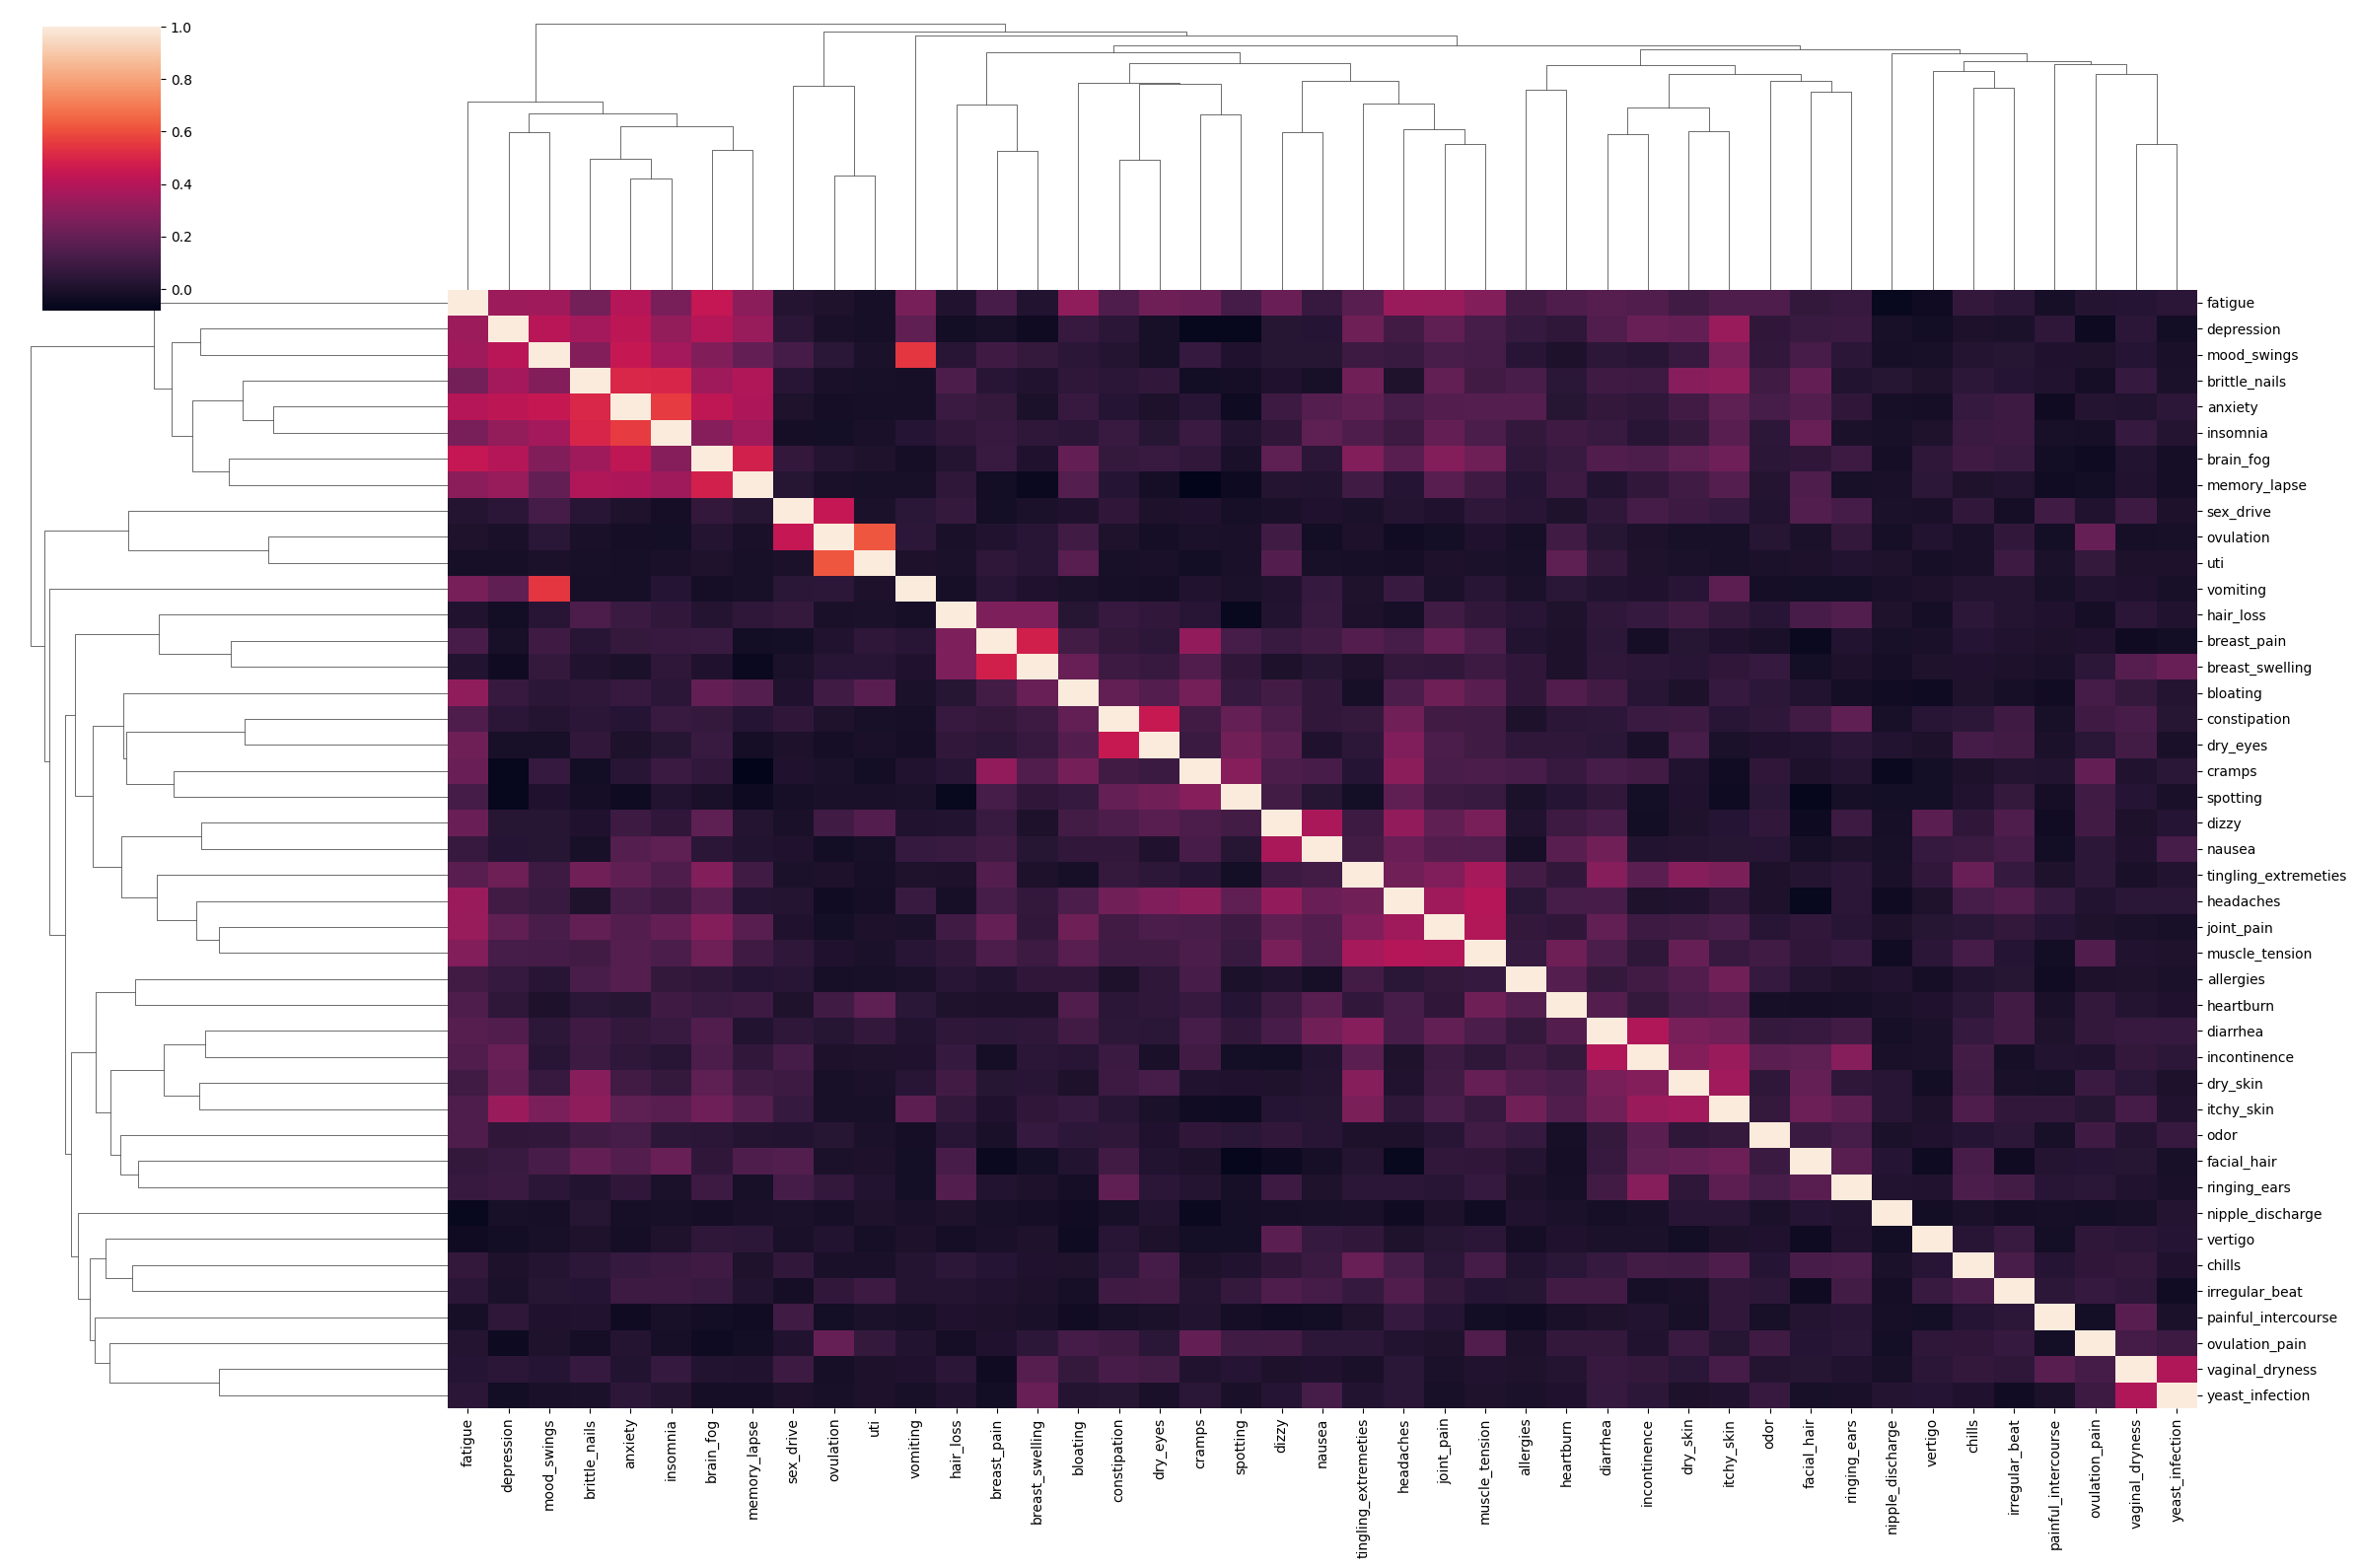

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create your hierarchical cluster map
hcluster = sns.clustermap(cmatrix, figsize=(24, 16))

# Save the figure as an image (e.g., PNG)
hcluster.savefig('HCA_premeno_irregularnovms_symptom_npt.png')

# Display the plot (optional)
plt.show()


In [111]:
#Note nothing to see from ARI or DBS. We don't have predetermined labels to compare to. 

# Step 1:  extract clustering labels
clustering_labels = hcluster.dendrogram_row.reordered_ind

# Step 2: Calculate ARI for different numbers of clusters (k)
max_clusters = 10  # Choose the maximum number of clusters to evaluate
ari_scores = []

for k in range(2, max_clusters + 1):
    # Replace 'KMeans' with your preferred clustering algorithm (e.g., DBSCAN)
    kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
    predicted_labels = kmeans.fit_predict(cmatrix)
    ari = adjusted_rand_score(clustering_labels, predicted_labels)
    ari_scores.append(ari)
    print(f"ARI for k={k}: {ari:.4f}")

# Step 3: Find the optimal number of clusters based on the ARI scores
optimal_k = ari_scores.index(max(ari_scores)) + 2  # Add 2 to account for k=2 being the starting value

print("Optimal number of clusters:", optimal_k)

# Use the optimal number of clusters for visualization or further analysis
# For example, you can run k-means again with optimal_k and plot the results.

ARI for k=2: 0.0000
ARI for k=3: 0.0000
ARI for k=4: 0.0000
ARI for k=5: 0.0000
ARI for k=6: 0.0000
ARI for k=7: 0.0000
ARI for k=8: 0.0000
ARI for k=9: 0.0000
ARI for k=10: 0.0000
Optimal number of clusters: 2


In [112]:
#Let's use silhouette score instead here. 
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import seaborn as sns

# Get the cluster assignments from the Seaborn plot
cluster_assignments = hcluster.dendrogram_row.reordered_ind

# Convert the cluster assignments to a NumPy array
cluster_assignments = np.array(cluster_assignments)

# Calculate the silhouette scores for different numbers of clusters
max_clusters = 10  # Set a reasonable maximum number of clusters to consider
silhouette_scores = []

for num_clusters in range(2, max_clusters + 1):
    # Perform hierarchical clustering with 'num_clusters'
    cluster_model = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
    cluster_model.fit(cmatrix)
    
    # Calculate the silhouette score for the current number of clusters
    score = silhouette_score(cmatrix, cluster_model.labels_)
    silhouette_scores.append(score)

# Find the optimal number of clusters that maximizes the silhouette score
optimal_num_clusters = np.argmax(silhouette_scores) + 2  # Adding 2 because range starts from 2

print("Optimal number of clusters:", optimal_num_clusters)


Optimal number of clusters: 9


In [ ]:
#Lol, no wonder, clusters are so weak for the premenopausal group! It's basically vague PMS

## Perform PCA analysis on the data.

In [113]:
from sklearn.decomposition import PCA

In [114]:
pca = PCA(n_components=15, svd_solver='full')
X = frame[symptoms]

In [115]:
pca.fit(X)

PCA(n_components=15, svd_solver='full')

In [116]:
evariance = pca.explained_variance_ratio_
cvariance = np.cumsum(evariance)

The variance from the various features is -

In [117]:
for i,v,c in zip(range(1, evariance.size+1), evariance, cvariance):
    print('PCA{} - {:.2f}, {:.2f}'.format(i, v, c))

PCA1 - 0.45, 0.45
PCA2 - 0.11, 0.55
PCA3 - 0.06, 0.61
PCA4 - 0.04, 0.66
PCA5 - 0.04, 0.70
PCA6 - 0.03, 0.73
PCA7 - 0.03, 0.76
PCA8 - 0.02, 0.78
PCA9 - 0.02, 0.80
PCA10 - 0.02, 0.82
PCA11 - 0.02, 0.84
PCA12 - 0.01, 0.85
PCA13 - 0.01, 0.86
PCA14 - 0.01, 0.88
PCA15 - 0.01, 0.89


Looks like we would need 12 principal components if we wanted to keep 90% of the variance. \
However the 2 components account for the majority of variance (64%), while an 80% variance is represented by 7 components.

In [118]:
pcacomponents = pca.fit_transform(X)

In [119]:
pcacomponents.shape

(738, 15)

In [120]:
# Get the impact of each feature on principal component.
impact = pca.components_.T
impact = pd.DataFrame(impact, index=symptoms, columns=pca.get_feature_names_out())

In [121]:
px.imshow(impact, 
          width=512,
          height=700,
          aspect='auto',
          title='Feature impact on principal component')

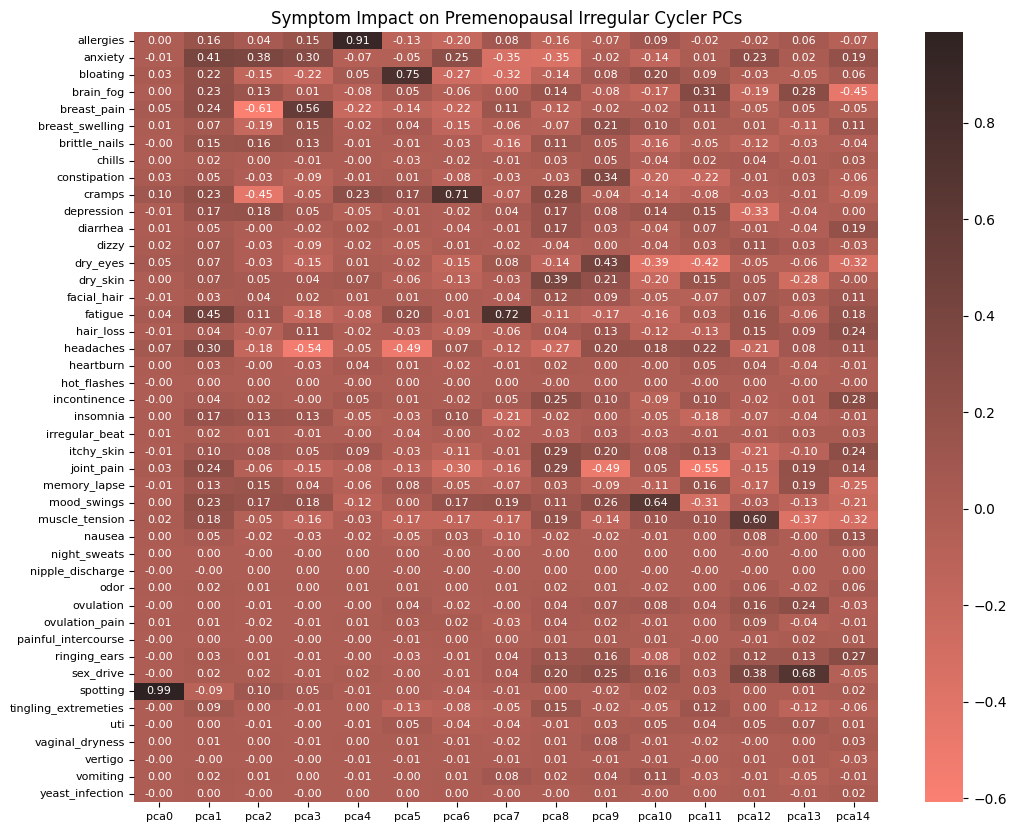

In [123]:
#Alt plot that shows every row label

import matplotlib.pyplot as plt
import seaborn as sns

# Create a light palette with the color 'seagreen'
cmap=sns.color_palette("dark:salmon_r", as_cmap=True)

# Assuming you already have the impact DataFrame 'impact' from your code
# impact = pd.DataFrame(impact, index=symptoms, columns=pca.get_feature_names_out())

# Create a heatmap using the custom colormap
plt.figure(figsize=(12, 10))
sns.heatmap(impact, cmap=cmap, annot=True, fmt=".2f", annot_kws={"size": 8})

# Adjust the font size of x-axis and y-axis tick labels
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Set the title and adjust its font size
plt.title('Symptom Impact on Premenopausal Irregular Cycler PCs', fontsize=12)

plt.show()


For the clustering we just pick the components that give 90% variance

In [124]:
pca = PCA(n_components=15, svd_solver='full')
pcacomponents = pca.fit_transform(X)
pcacomponents.shape

(738, 15)

In [125]:
from sklearn.cluster import KMeans

## Determining the optimal cluster size.

### Elbow Method

In [126]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    sse.append(kmeans.inertia_)

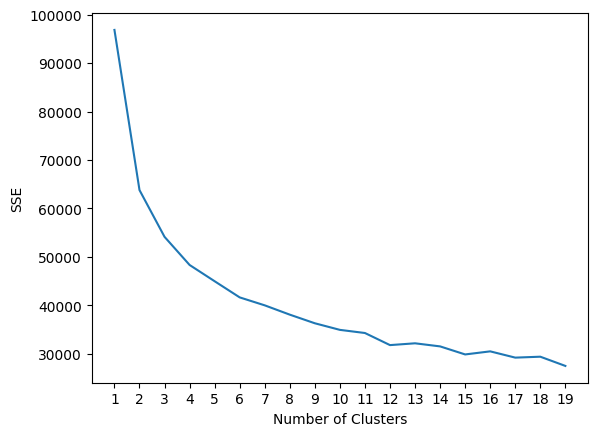

In [127]:
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [128]:
from kneed import KneeLocator

kl = KneeLocator(
    range(1, 20), sse, curve="convex", direction="decreasing"
)

kl.knee

4

Conclusion - Based on the elbow method, it looks like the optimal number of clusters would be **4**

### Silhouette Coefficient

Is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:
* How close the data point is to other points in the cluster
* How far away the data point is from points in other clusters

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

In [129]:
from sklearn.metrics import silhouette_score

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    score = silhouette_score(pcacomponents, kmeans.labels_)
    silhouette_coefficients.append(score)

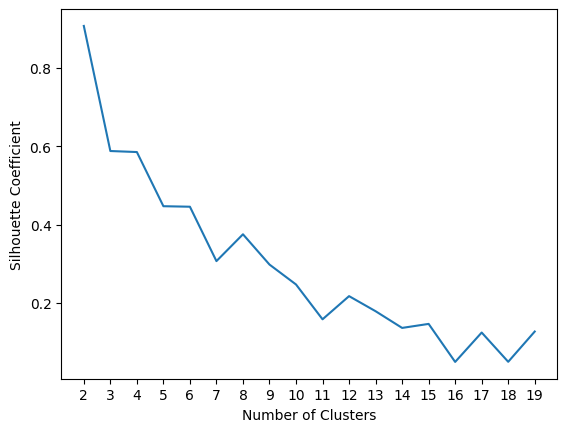

In [130]:
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [131]:
from kneed import KneeLocator

kl = KneeLocator(
    range(1, 20), sse, curve="convex", direction="decreasing"
)

kl.knee

4

Conclusion - From silhouette coeff it looks like the score is maximized for n=3 and then for n=5.
n=3 might be too small of a number of clusters. We will pick n=5 based on the elbow method + S method.

## Cluster them using k-means clustering

In [132]:
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))

0 - 36
1 - 3
2 - 663
3 - 36


## Get the users which belong to each of these clusters

In [133]:
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]

## Find the top 5 symptoms reported by frequency for each of these segments.

In [134]:
def getTopSymptoms(users, top=5):
    # Create the where statement that will be used to filter by these users.
    where_query = "uid = '{}'".format(users[0])
    for i in range(1, len(users)):
        where_query += " or uid = '{}'".format(users[i])
        
    query = """
        select name, count(name) occ from symptoms 
            where {where}
            group by name
            order by occ desc
            limit {top}
    """.format(where=where_query, top=top)
    
    results = db.execQuery(query, cached=True)
    
    return results

In [135]:

## If the block above throws an error - use this. 
def getTopSymptoms(users, top=5):
    if len(users) == 0:
        return pd.DataFrame(columns=['name', 'occ'])  # Return an empty DataFrame if no users in the segment
    
    where_query = "uid IN ('{}')".format("','".join(users))
    
    query = """
        SELECT name, COUNT(name) AS occ FROM symptoms 
        WHERE {where}
        GROUP BY name
        ORDER BY occ DESC
        LIMIT {top}
    """.format(where=where_query, top=top)
    
    results = db.execQuery(query, cached=True)
    return results


In [136]:
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values

In [137]:
for (i,s) in enumerate(segments):
    print('Segment {}'.format(i))
    print(s)

Segment 0
['spotting' 'cramps' 'breast_pain' 'headaches' 'bloating']
Segment 1
['spotting' 'cramps' 'dry_eyes' 'fatigue' 'headaches']
Segment 2
['fatigue' 'bloating' 'cramps' 'anxiety' 'headaches']
Segment 3
['fatigue' 'breast_pain' 'anxiety' 'joint_pain' 'headaches']


Summary of cohort symptoms -

PCA + Clustering was able to isolate the users into 4 clusters based on the occurance of their symptom reporting.a

In [ ]:
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))
    
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]
    
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values
    
for (i,s) in enumerate(segments):
    print('Segment {}'.format(i))
    print(s)

0 - 5825
1 - 1
2 - 2


InvalidRequestException: An error occurred (InvalidRequestException) when calling the StartQueryExecution operation: 

In [62]:
import pandas as pd
import numpy as np
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy as scipy
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import utils

In [63]:
from sensorfabric.athena import athena

In [64]:
# Establish connection with the database using PyAthena.
cursor = connect(s3_staging_dir='s3://menolife-opensci/athena/',
                  schema_name='menolife',
                  cursor_class=PandasCursor,
                  work_group='amyris',
                  region_name='us-east-1'
                ).cursor()

In [65]:
%set_env AWS_PROFILE=opensci

env: AWS_PROFILE=opensci


In [66]:
db = athena(database='menolife', workgroup='amyris', offlineCache=True)

In [15]:


premenopausalusers_symptoms_query = """

WITH query1 AS (

    SELECT DISTINCT healthid
    FROM onboardingpp o
    WHERE (questions = 'How would you describe your periods?')
        AND length(answers) > 0
        AND answers NOT LIKE '%have a period anymore%'
        AND answers NOT LIKE '%take birth control%'
),

query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptompp_npt s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        and symptoms_recorded>10
        and symptoms_recorded<300
        AND ss.uid IN (SELECT DISTINCT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)

SELECT q2.uid, o.questions, o.answers
FROM query2 q2
INNER JOIN onboardingpp o ON q2.uid = o.healthid
ORDER BY q2.uid, o.questions, q2.count DESC;

   

"""

premenopausalusers_symptoms = db.execQuery(premenopausalusers_symptoms_query, cached=True)
print(premenopausalusers_symptoms.shape)



(139829, 3)


?Shravan - How many people who we classified as pre-menopausal also report classic memopause symptoms like hot-flashes and night sweats.

In [16]:
special = frame[(frame['hot_flashes'] > 0) | (frame['night_sweats'] > 0)]

In [ ]:
print(special.shape)
print(frame.shape)
print(special.shape[0]/frame.shape[0])

(2437, 45)
(3775, 45)
0.6455629139072848


~64% of the user who have been classified in the pre-menopause group report having hot flashes or night sweats.

There are 2,437 users 

In [ ]:
# Calculate the total count of each symptom type (sum across columns)
symptom_totals = special.sum(axis=0)

# Calculate the total count of all symptoms
total_symptom_count = symptom_totals.sum()

# Calculate the percentage of each symptom type's count relative to the total count of all symptoms
symptom_percentages = (symptom_totals / total_symptom_count) * 100

# Sort the symptom_percentages in descending order (most frequent to least frequent)
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

# Print out each symptom type and its corresponding percentage in the sorted order
c = 0
for symptom, count in zip(symptom_percentages_sorted.index, symptom_percentages_sorted.values):
    c += 1
    print(f"{symptom}: {count:.2f}%")
    if c > 100:
        break

hot_flashes: 12.12%
fatigue: 6.44%
headaches: 4.97%
bloating: 4.39%
cramps: 4.35%
anxiety: 4.16%
joint_pain: 4.04%
night_sweats: 3.86%
allergies: 3.81%
dry_skin: 3.41%
muscle_tension: 2.88%
insomnia: 2.83%
brain_fog: 2.77%
dry_eyes: 2.65%
mood_swings: 2.51%
breast_pain: 2.45%
spotting: 2.44%
brittle_nails: 2.43%
depression: 2.20%
itchy_skin: 2.11%
ringing_ears: 1.78%
chills: 1.65%
dizzy: 1.58%
sex_drive: 1.42%
nausea: 1.41%
constipation: 1.35%
facial_hair: 1.34%
diarrhea: 1.34%
tingling_extremeties: 1.34%
incontinence: 1.18%
hair_loss: 1.12%
irregular_beat: 1.11%
heartburn: 1.03%
memory_lapse: 1.03%
breast_swelling: 0.98%
odor: 0.98%
vaginal_dryness: 0.72%
ovulation_pain: 0.49%
vertigo: 0.38%
ovulation: 0.22%
vomiting: 0.20%
yeast_infection: 0.18%
painful_intercourse: 0.16%
uti: 0.14%
nipple_discharge: 0.06%


### Unpredictable with No VMS is the Cohort We are Looking For

In [46]:
import utils
unpredictable_uids = db.execQuery('select uid from premeno_period_unpredictable', cached=True) #ok i guess we had a table called that already...convenient

In [47]:
unpredictable = frame[frame.index.isin(unpredictable_uids['uid'].values)]

In [48]:
unpredictablenovms=unpredictable[(unpredictable['hot_flashes'] == 0) & (unpredictable['night_sweats'] == 0)]

In [21]:
#utils.symPercentages(unpredictable)

In [22]:
#unpredictablewvms = special[special.index.isin(unpredictable_uids['uid'].values)]

NameError: name 'special' is not defined

In [26]:
#utils.symPercentages(unpredictablewvms)

NameError: name 'unpredictablewvms' is not defined

## Regular no vms and Regular w/ vms

In [17]:
regular_uids = db.execQuery('select uid from premeno_period_regular', cached=True)
regular = frame[frame.index.isin(regular_uids['uid'].values)]
utils.symPercentages(regular)

fatigue: 6.71%
bloating: 6.10%
cramps: 5.65%
headaches: 5.55%
hot_flashes: 4.23%
anxiety: 4.13%
allergies: 3.83%
joint_pain: 3.83%
breast_pain: 3.54%
dry_skin: 3.38%
dry_eyes: 3.36%
brain_fog: 3.36%
spotting: 3.16%
muscle_tension: 2.84%
night_sweats: 2.69%
mood_swings: 2.56%
insomnia: 2.45%
brittle_nails: 2.32%
ringing_ears: 2.20%
depression: 2.02%
itchy_skin: 1.99%
sex_drive: 1.76%
constipation: 1.68%
dizzy: 1.67%
breast_swelling: 1.67%
diarrhea: 1.56%
hair_loss: 1.47%
nausea: 1.44%
facial_hair: 1.44%
irregular_beat: 1.39%
tingling_extremeties: 1.29%
incontinence: 1.27%
chills: 1.19%
odor: 1.18%
memory_lapse: 1.03%
heartburn: 0.99%
vaginal_dryness: 0.81%
ovulation_pain: 0.60%
vertigo: 0.46%
ovulation: 0.45%
yeast_infection: 0.22%
painful_intercourse: 0.19%
vomiting: 0.17%
uti: 0.13%
nipple_discharge: 0.05%


In [19]:
regularnovms=regular[(regular['hot_flashes'] == 0) & (regular['night_sweats'] == 0)]

In [20]:
regularwvms=regular[(regular['hot_flashes'] > 0) | (regular['night_sweats'] > 0)]

## So now we have 3 groups we care about here

### all women who are not menopausal, all women who are additionally regular and display no hot flashes, and women who are not menopausal but irregular and DO have hot flasehs

#frame is all premeno (if not runing the line below to remove HFs);unpredictablewvms = putative perimenopausal; regularnovms. we also have unpredictable

In [22]:
#Let's Identify the number of UIDs in each group

#Now how many do I have who are unpredictable with VMS
unique_uids = regularnovms.index.unique().tolist()
unique_uids_size = len(unique_uids)
print("Size of Regular with No Vasomotor Symptoms:", unique_uids_size)


Size of Regular with No Vasomotor Symptoms: 468


In [37]:
#Now how many do I have who are Regular with VMS
unique_uids = regularwvms.index.unique().tolist()
unique_uids_size = len(unique_uids)
print("Size of Regular With Vasomotor Symptoms:", unique_uids_size)

Size of Regular With Vasomotor Symptoms: 685


In [49]:
#Now how many do I have left?

unique_uids = unpredictablenovms.index.unique().tolist()
unique_uids_size = len(unique_uids)
print("Size of unique_uids:", unique_uids_size)

Size of unique_uids: 738


In [28]:
unpredictablenovms.to_csv('premenopausalsymptoms_unpredictablenovms_npt_correct.csv')

In [29]:
unpredictablenovms.head()

dry_eyes  spotting  brain_fog  memory_lapse  nausea  \
uid                                                                             
5f98bab244eca8ead4eca209         4         3          2             1       1   
5f9b22b7d01db71874617a55         1         9          5             0       3   
5fec91a88c7e61fc62131b1c         0         0          0             0       0   
6022a6fdbea29a1eb66b6fe0         1         0          0             0       0   
60ab0ca1bea29a1eb66c61a0         1         0          1             0       0   

                          dry_skin  vertigo  anxiety  bloating  chills  ...  \
uid                                                                     ...   
5f98bab244eca8ead4eca209         1        1        1         1       1  ...   
5f9b22b7d01db71874617a55         0        0        0         1       0  ...   
5fec91a88c7e61fc62131b1c         1        0        4         0       0  ...   
6022a6fdbea29a1eb66b6fe0         0        1        4         0       0  ...   
60ab0ca1bea29a1eb66c61a0         0        0        1         0       0  ...   

                          vaginal_dryness  itchy_skin  ovulation_pain  \
uid                                                                     
5f98bab244eca8ead4eca209                0           0               0   
5f9b22b7d01db71874617a55                0           0               0   
5fec91a88c7e61fc62131b1c                0           0               0   
6022a6fdbea29a1eb66b6fe0                0           0               0   
60ab0ca1bea29a1eb66c61a0                0           1               0   

                          ovulation  odor  uti  nipple_discharge  \
uid                                                                
5f98bab244eca8ead4eca209          0     0    0                 0   
5f9b22b7d01db71874617a55          0     0    0                 0   
5fec91a88c7e61fc62131b1c          0     0    0                 0   
6022a6fdbea29a1eb66b6fe0          0     0    0                 0   
60ab0ca1bea29a1eb66c61a0          0     1    0                 0   

                          yeast_infection  painful_intercourse  vomiting  
uid                                                                       
5f98bab244eca8ead4eca209                0                    0         0  
5f9b22b7d01db71874617a55                0                    0         0  
5fec91a88c7e61fc62131b1c                0                    0         0  
6022a6fdbea29a1eb66b6fe0                0                    0         0  
60ab0ca1bea29a1eb66c61a0                0                    0         0  

[5 rows x 45 columns]

In [50]:
unpredictablenovms.shape

(738, 45)

In [54]:
data_type = unpredictablenovms[symptoms].dtypes
#print(data_type)

## Create One Hot Encoding for Network Analysis

In [32]:
encoding = unpredictablenovms.copy(deep=True)
def replace_map(x):
    if x > 0:
        return 1
    else:
        return 0
encoding = encoding.applymap(replace_map)

encoding.to_csv('symptoms_premenopause_unpredictablenovms_npt_onehot.csv', index=False)

## What's the distribution of symptoms by UID, and total Number of symptoms?

In [33]:
total_symptom_count_per_uid = unpredictablenovms.sum(axis=1)

# Overall sum of all symptom counts
overall_total_symptom_count = total_symptom_count_per_uid.sum()

#print("Total symptom count per UID:")
#print(total_symptom_count_per_uid)

print("\nOverall total symptom count:")
print(overall_total_symptom_count)


Overall total symptom count:
18046


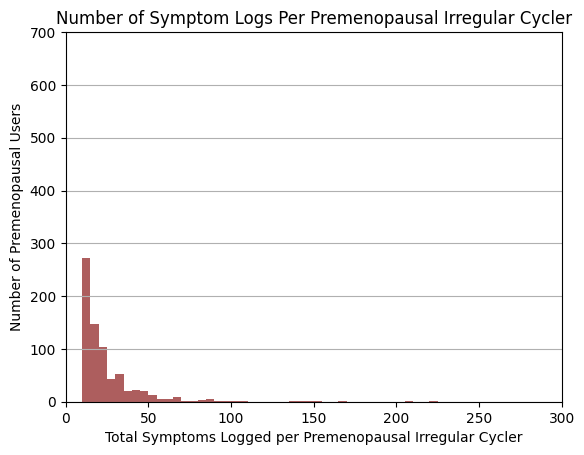

Median Symptoms per User: 17.0
Median Absolute Deviation (MAD) of Symptoms per User: 5.0


In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the 'frame' dataframe with symptom counts

# Total symptom count for each UID
total_symptom_count_per_uid = unpredictablenovms.sum(axis=1)

# Calculate the total symptoms per user
total_symptoms_per_user = total_symptom_count_per_uid.values

# Calculate the median and median absolute deviation
median_symptoms_per_user = np.median(total_symptoms_per_user)
mad_symptoms_per_user = np.median(np.abs(total_symptoms_per_user - median_symptoms_per_user))


# Create histogram with specified bins
bins = range(0, max(total_symptoms_per_user) + 5, 5)

plt.hist(total_symptoms_per_user, bins=bins, edgecolor='none', alpha=0.7,color=(139/255,26/255,26/255))
plt.xlabel('Total Symptoms Logged per Premenopausal Irregular Cycler')
plt.ylabel('Number of Premenopausal Users')
plt.title('Number of Symptom Logs Per Premenopausal Irregular Cycler')
plt.grid(axis='y')
plt.ylim(0,700) #note it goes up to about 2500
plt.xlim(0, 300) #note some rando users log >500 symptoms. Should we omit them?
plt.show()

print("Median Symptoms per User:", median_symptoms_per_user)
print("Median Absolute Deviation (MAD) of Symptoms per User:", mad_symptoms_per_user)


## Symptom Frequency by % of Total Symptoms, For Each Symptom

In [36]:
# Calculate the total count of each symptom type (sum across columns)
symptom_totals = unpredictablenovms.sum(axis=0)

# Calculate the total count of all symptoms
total_symptom_count = symptom_totals.sum()

# Calculate the percentage of each symptom type's count relative to the total count of all symptoms
symptom_percentages = (symptom_totals / total_symptom_count) * 100

# Sort the symptom_percentages in descending order (most frequent to least frequent)
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

# Print out each symptom type and its corresponding percentage in the sorted order
c = 0
for symptom, count in zip(symptom_percentages_sorted.index, symptom_percentages_sorted.values):
    c += 1
    print(f"{symptom}: {count:.2f}%")
    if c > 100:
        break

spotting: 8.44%
fatigue: 7.77%
cramps: 6.63%
bloating: 6.13%
headaches: 5.23%
anxiety: 5.17%
breast_pain: 4.21%
joint_pain: 3.95%
brain_fog: 3.61%
allergies: 3.31%
mood_swings: 3.27%
depression: 2.93%
muscle_tension: 2.75%
dry_skin: 2.67%
itchy_skin: 2.39%
dry_eyes: 2.16%
insomnia: 2.09%
hair_loss: 1.94%
dizzy: 1.83%
memory_lapse: 1.81%
sex_drive: 1.77%
constipation: 1.75%
brittle_nails: 1.72%
facial_hair: 1.65%
breast_swelling: 1.56%
ringing_ears: 1.45%
tingling_extremeties: 1.39%
diarrhea: 1.29%
nausea: 1.28%
incontinence: 1.10%
irregular_beat: 1.03%
heartburn: 0.85%
chills: 0.84%
odor: 0.83%
vaginal_dryness: 0.73%
ovulation_pain: 0.66%
vertigo: 0.56%
ovulation: 0.49%
uti: 0.24%
painful_intercourse: 0.18%
yeast_infection: 0.16%
vomiting: 0.13%
nipple_discharge: 0.06%
hot_flashes: 0.00%
night_sweats: 0.00%


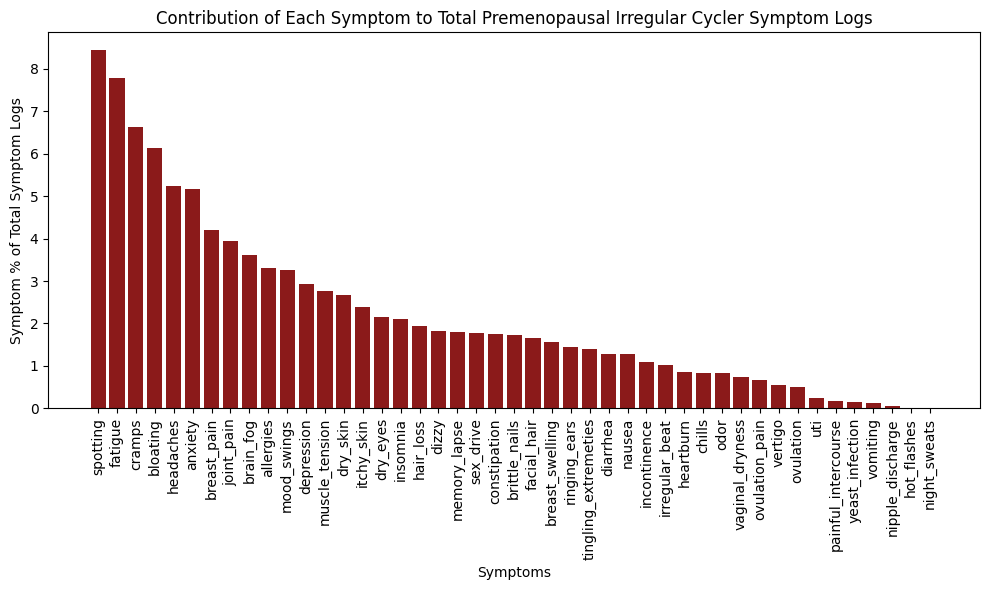

In [37]:
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.bar(symptom_percentages_sorted.index, symptom_percentages_sorted.values,color=(139/255,26/255,26/255))
plt.xlabel("Symptoms")
plt.ylabel("Symptom % of Total Symptom Logs")
plt.title("Contribution of Each Symptom to Total Premenopausal Irregular Cycler Symptom Logs")
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent cropping of labels
plt.show()

## Symptom Frequency by % of Users Reporting that Symptom

In [55]:
frame=unpredictablenovms

In [56]:
# Step 1: Calculate the total number of users
total_users = len(frame)

# Step 2: Calculate the percentage of users who have each symptom
symptom_percentages = (frame.astype(bool).sum() / total_users) * 100

print(symptom_percentages.sort_values(ascending=False))

fatigue                 75.474255
bloating                62.737127
cramps                  57.317073
anxiety                 52.710027
headaches               50.542005
brain_fog               46.883469
joint_pain              46.341463
mood_swings             41.463415
depression              37.127371
spotting                36.991870
breast_pain             36.449864
dry_skin                36.043360
allergies               34.688347
muscle_tension          34.146341
itchy_skin              32.655827
insomnia                29.539295
facial_hair             28.048780
dry_eyes                27.777778
hair_loss               27.235772
dizzy                   26.964770
memory_lapse            26.558266
brittle_nails           24.796748
sex_drive               24.254743
constipation            23.441734
tingling_extremeties    22.764228
diarrhea                19.918699
nausea                  19.512195
ringing_ears            17.615176
breast_swelling         17.344173
irregular_beat

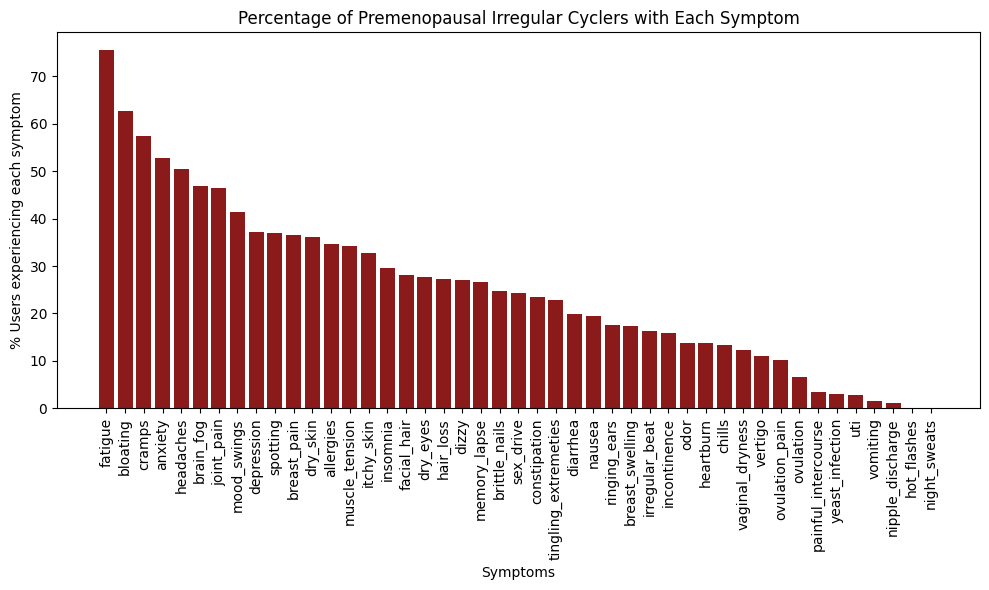

In [57]:
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.bar(symptom_percentages_sorted.index, symptom_percentages_sorted.values,color=(139/255,26/255,26/255))
plt.xlabel("Symptoms")
plt.ylabel("% Users experiencing each symptom")
plt.title("Percentage of Premenopausal Irregular Cyclers with Each Symptom")
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent cropping of labels
plt.show()

## Covariance matrix of the features

Standardize the features first.

In [58]:
data_type = frame[symptoms].dtypes
print(data_type)

import pandas as pd
import numpy as np

# Assuming 'frame' is your DataFrame and 'symptoms' is a list of column names
# First, replace Inf values with NaN
frame.replace([np.inf, -np.inf], np.nan, inplace=True)

# Then, drop rows containing NA or NaN values
frame.dropna(subset=symptoms, inplace=True)

# Remove non-numeric columns from the DataFrame
sframe = frame.select_dtypes(include=[np.number])

# Now, convert the content of the remaining numeric columns to int64
sframe = sframe.astype('int64')

# Now you can proceed with the rest of your code
sframe = (sframe - sframe.mean()) / sframe.std()




dry_eyes                float64
spotting                float64
brain_fog               float64
memory_lapse            float64
nausea                  float64
dry_skin                float64
vertigo                 float64
anxiety                 float64
bloating                float64
chills                  float64
breast_pain             float64
fatigue                 float64
depression              float64
breast_swelling         float64
insomnia                float64
night_sweats            float64
headaches               float64
muscle_tension          float64
tingling_extremeties    float64
irregular_beat          float64
brittle_nails           float64
diarrhea                float64
joint_pain              float64
ringing_ears            float64
hot_flashes             float64
incontinence            float64
sex_drive               float64
mood_swings             float64
heartburn               float64
constipation            float64
facial_hair             float64
cramps  

KeyError: [['allergies'], ['anxiety'], ['bloating'], ['brain_fog'], ['breast_pain'], ['breast_swelling'], ['brittle_nails'], ['chills'], ['constipation'], ['cramps'], ['depression'], ['diarrhea'], ['dizzy'], ['dry_eyes'], ['dry_skin'], ['facial_hair'], ['fatigue'], ['hair_loss'], ['headaches'], ['heartburn'], ['hot_flashes'], ['incontinence'], ['insomnia'], ['irregular_beat'], ['itchy_skin'], ['joint_pain'], ['memory_lapse'], ['mood_swings'], ['muscle_tension'], ['nausea'], ['night_sweats'], ['nipple_discharge'], ['odor'], ['ovulation'], ['ovulation_pain'], ['painful_intercourse'], ['ringing_ears'], ['sex_drive'], ['spotting'], ['tingling_extremeties'], ['uti'], ['vaginal_dryness'], ['vertigo'], ['vomiting'], ['yeast_infection']]

In [42]:
sframe = frame[symptoms].astype('int64') #removed the [symptoms]
sframe = (sframe - sframe.mean()) / sframe.std()

## Visualizing the distribution of some of the syptoms

Hotflashes

/home/ubuntu/anaconda3/envs/menolife/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


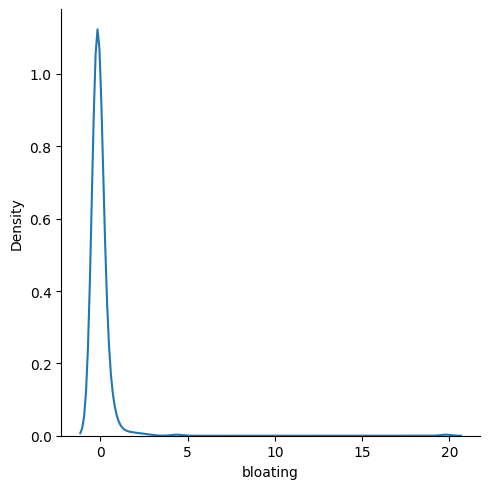

In [40]:
sns.displot(sframe, x='bloating', kind='kde')

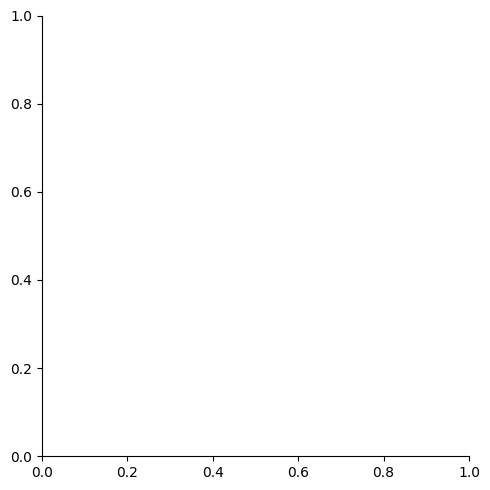

In [ ]:
sns.displot(sframe, x='hot_flashes', kind='kde')

In [38]:
cmatrix = sframe.cov()

# List of symptom names to remove
symptoms_to_remove = ["hot_flashes", "night_sweats"]

# Step 1: Drop the specified rows and columns from the covariance matrix
cmatrix = cmatrix.drop(symptoms_to_remove, axis=0).drop(symptoms_to_remove, axis=1)

# Step 2: Print the filtered covariance matrix
#print(filtered_cmatrix)


In [39]:
cmatrix.to_csv('premeno_irregular_novms_correct_symptom_covariance.csv', index=True)

In [40]:
fig = px.imshow(cmatrix, 
                width=2000, 
                height=1024, 
                text_auto=True, 
                aspect='auto',
                title='Symptom Covariance')
fig.show()
# Also go ahead and save this figure.
fig.write_image('premeno_irregularnovms_symptom_covariance.png')

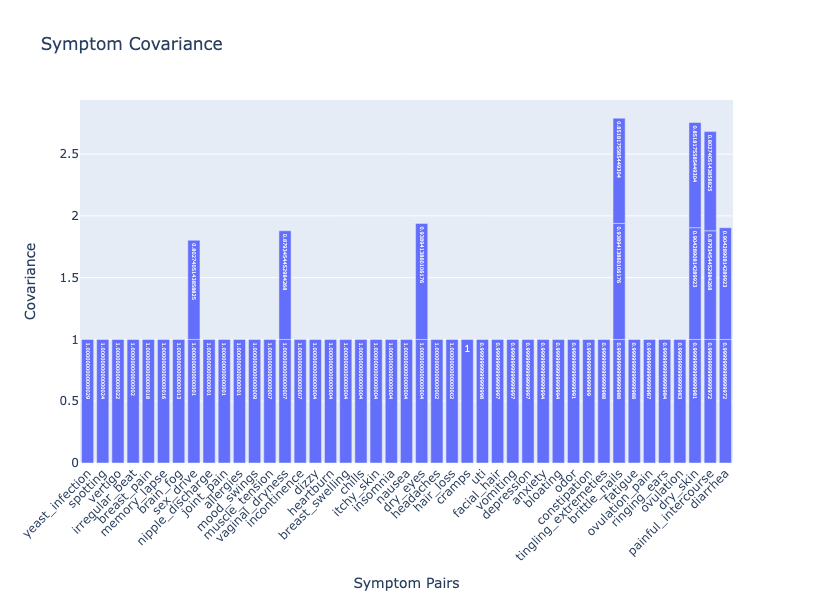

brittle_nails - dry_eyes - 0.9389413860106176
dry_eyes - brittle_nails - 0.9389413860106176
diarrhea - dry_skin - 0.9042890814289923
dry_skin - diarrhea - 0.9042890814289923
painful_intercourse - vaginal_dryness - 0.8793454452984268
vaginal_dryness - painful_intercourse - 0.8793454452984268
brittle_nails - dry_skin - 0.8518175585449304
dry_skin - brittle_nails - 0.8518175585449304
painful_intercourse - sex_drive - 0.8027405143858825
sex_drive - painful_intercourse - 0.8027405143858825
allergies - anxiety - nan
allergies - bloating - nan
allergies - brain_fog - nan
allergies - breast_pain - nan
allergies - breast_swelling - nan
allergies - brittle_nails - nan
allergies - chills - nan
allergies - constipation - nan
allergies - cramps - nan
allergies - depression - nan
allergies - diarrhea - nan
allergies - dizzy - nan
allergies - dry_eyes - nan
allergies - dry_skin - nan
allergies - facial_hair - nan
allergies - fatigue - nan
allergies - hair_loss - nan
allergies - headaches - nan
allerg

In [ ]:
#Alt covariance plot to properly display y axis titles

import plotly.graph_objs as go
import plotly.express as px

th = 0.8
fmatrix = cmatrix[cmatrix >= th]

# Step 1: Remove 'hot_flashes' and 'night_sweats' from the fmatrix
#fmatrix = fmatrix.drop(['hot_flashes', 'night_sweats'], axis=0)
#fmatrix = fmatrix.drop(['hot_flashes', 'night_sweats'], axis=1)

# Step 2: Sort the covariance matrix in descending order of covariance
sorted_cov_matrix = fmatrix.unstack().sort_values(ascending=False)

# Step 3: Create a bar graph to visualize the covariance by symptom pair
sorted_cov_matrix_df = sorted_cov_matrix.reset_index()
sorted_cov_matrix_df.columns = ['Symptom 1', 'Symptom 2', 'Covariance']

fig = px.bar(sorted_cov_matrix_df,
             x='Symptom 1',
             y='Covariance',
             text='Covariance',
             title='Symptom Covariance',
             labels={'Symptom 1': 'Symptom Pairs', 'Covariance': 'Covariance'},
             width=1024,
             height=600)
fig.update_layout(xaxis_tickangle=-45)  # Rotate x-axis labels for better readability
fig.show()

# Step 4: Create a dictionary to store the counts of each symptom pair
symptom_pair_counts = {}

# Step 5: Iterate through the sorted DataFrame to count occurrences of each symptom pair
for _, row in sorted_cov_matrix_df.iterrows():
    symptom1 = row['Symptom 1']
    symptom2 = row['Symptom 2']
    covariance = row['Covariance']
    if not (symptom1 == symptom2):
        symptom_pair = f"{symptom1} - {symptom2}"
        count = fmatrix.loc[symptom1, symptom2]
        symptom_pair_counts[symptom_pair] = count

        
# Step 4: Print out the symptom pairs in order from highest to lowest covariance
for _, row in sorted_cov_matrix_df.iterrows():
    symptom1 = row['Symptom 1']
    symptom2 = row['Symptom 2']
    covariance = row['Covariance']
    if not (symptom1 == symptom2):
        print(f'{symptom1} - {symptom2} - {covariance}') #uncomment me to run

## Find pairs of symptoms with more than 80% corelation.

In [41]:
import pandas as pd
import plotly.express as px

th=0.8

fmatrix = cmatrix[cmatrix >= th]

# create the heatmap with the updated 'fmatrix'
fig = px.imshow(fmatrix,
                width=1024,
                height=1024,
                text_auto=True,
                aspect='auto',
                title='Symptom Covariance')
fig.show()

indexes = fmatrix.index.values
for s in symptoms:
    if s not in ['hot_flashes', 'night_sweats']:  # Exclude 'hot_flashes' and 'night_sweats' from iteration
        paired = fmatrix[s].dropna().index.values
        # We can go ahead and print it out.
        for p in paired:
            if not (s == p):
                print('{} - {} - {}'.format(s, p, fmatrix.loc[s][p]))


brittle_nails - dry_skin - 0.9084511795970378
brittle_nails - hair_loss - 0.91176533481349
dry_skin - brittle_nails - 0.9084511795970378
dry_skin - hair_loss - 0.8645061642501645
hair_loss - brittle_nails - 0.91176533481349
hair_loss - dry_skin - 0.8645061642501645


In [48]:
import pandas as pd
import plotly.express as px

th = 0.8

fmatrix = cmatrix[cmatrix >= th]

# create the heatmap with the updated 'fmatrix'
fig = px.imshow(fmatrix,
                width=1024,
                height=1024,
                text_auto=True,
                aspect='auto',
                title='Symptom Covariance')
fig.show()

# Create an empty list to store the results
covariance_results = []

indexes = fmatrix.index.values
for s in symptoms:
    if s not in ['hot_flashes', 'night_sweats']:  # Exclude 'hot_flashes' and 'night_sweats' from iteration
        paired = fmatrix[s].dropna().index.values
        # We can go ahead and calculate the covariance and store the results in the list.
        for p in paired:
            if not (s == p):
                covariance = fmatrix.loc[s][p]
                covariance_results.append({'Symptom1': s, 'Symptom2': p, 'Covariance': covariance})

# Convert the list to a DataFrame
covariance_results_df = pd.DataFrame(covariance_results)

# Sort the DataFrame by the 'Covariance' column in descending order
covariance_results_df = covariance_results_df.sort_values(by='Covariance', ascending=False)

# Print the sorted results
print(covariance_results_df)


               Symptom1             Symptom2  Covariance
2         brittle_nails             dry_eyes    0.970050
6              dry_eyes        brittle_nails    0.970050
5              diarrhea             dry_skin    0.968431
8              dry_skin             diarrhea    0.968431
19      vaginal_dryness  painful_intercourse    0.945473
12  painful_intercourse      vaginal_dryness    0.945473
10  painful_intercourse            sex_drive    0.927596
13            sex_drive  painful_intercourse    0.927596
15            sex_drive      vaginal_dryness    0.890019
20      vaginal_dryness            sex_drive    0.890019
4              diarrhea        brittle_nails    0.863733
1         brittle_nails             diarrhea    0.863733
21      vaginal_dryness                  uti    0.860322
18                  uti      vaginal_dryness    0.860322
0              bloating            hair_loss    0.859310
9             hair_loss             bloating    0.859310
16                  uti  painfu

### Notes

With super users filtered out -- there are MUCH weaker pairwise correlations.

## Cluster Map

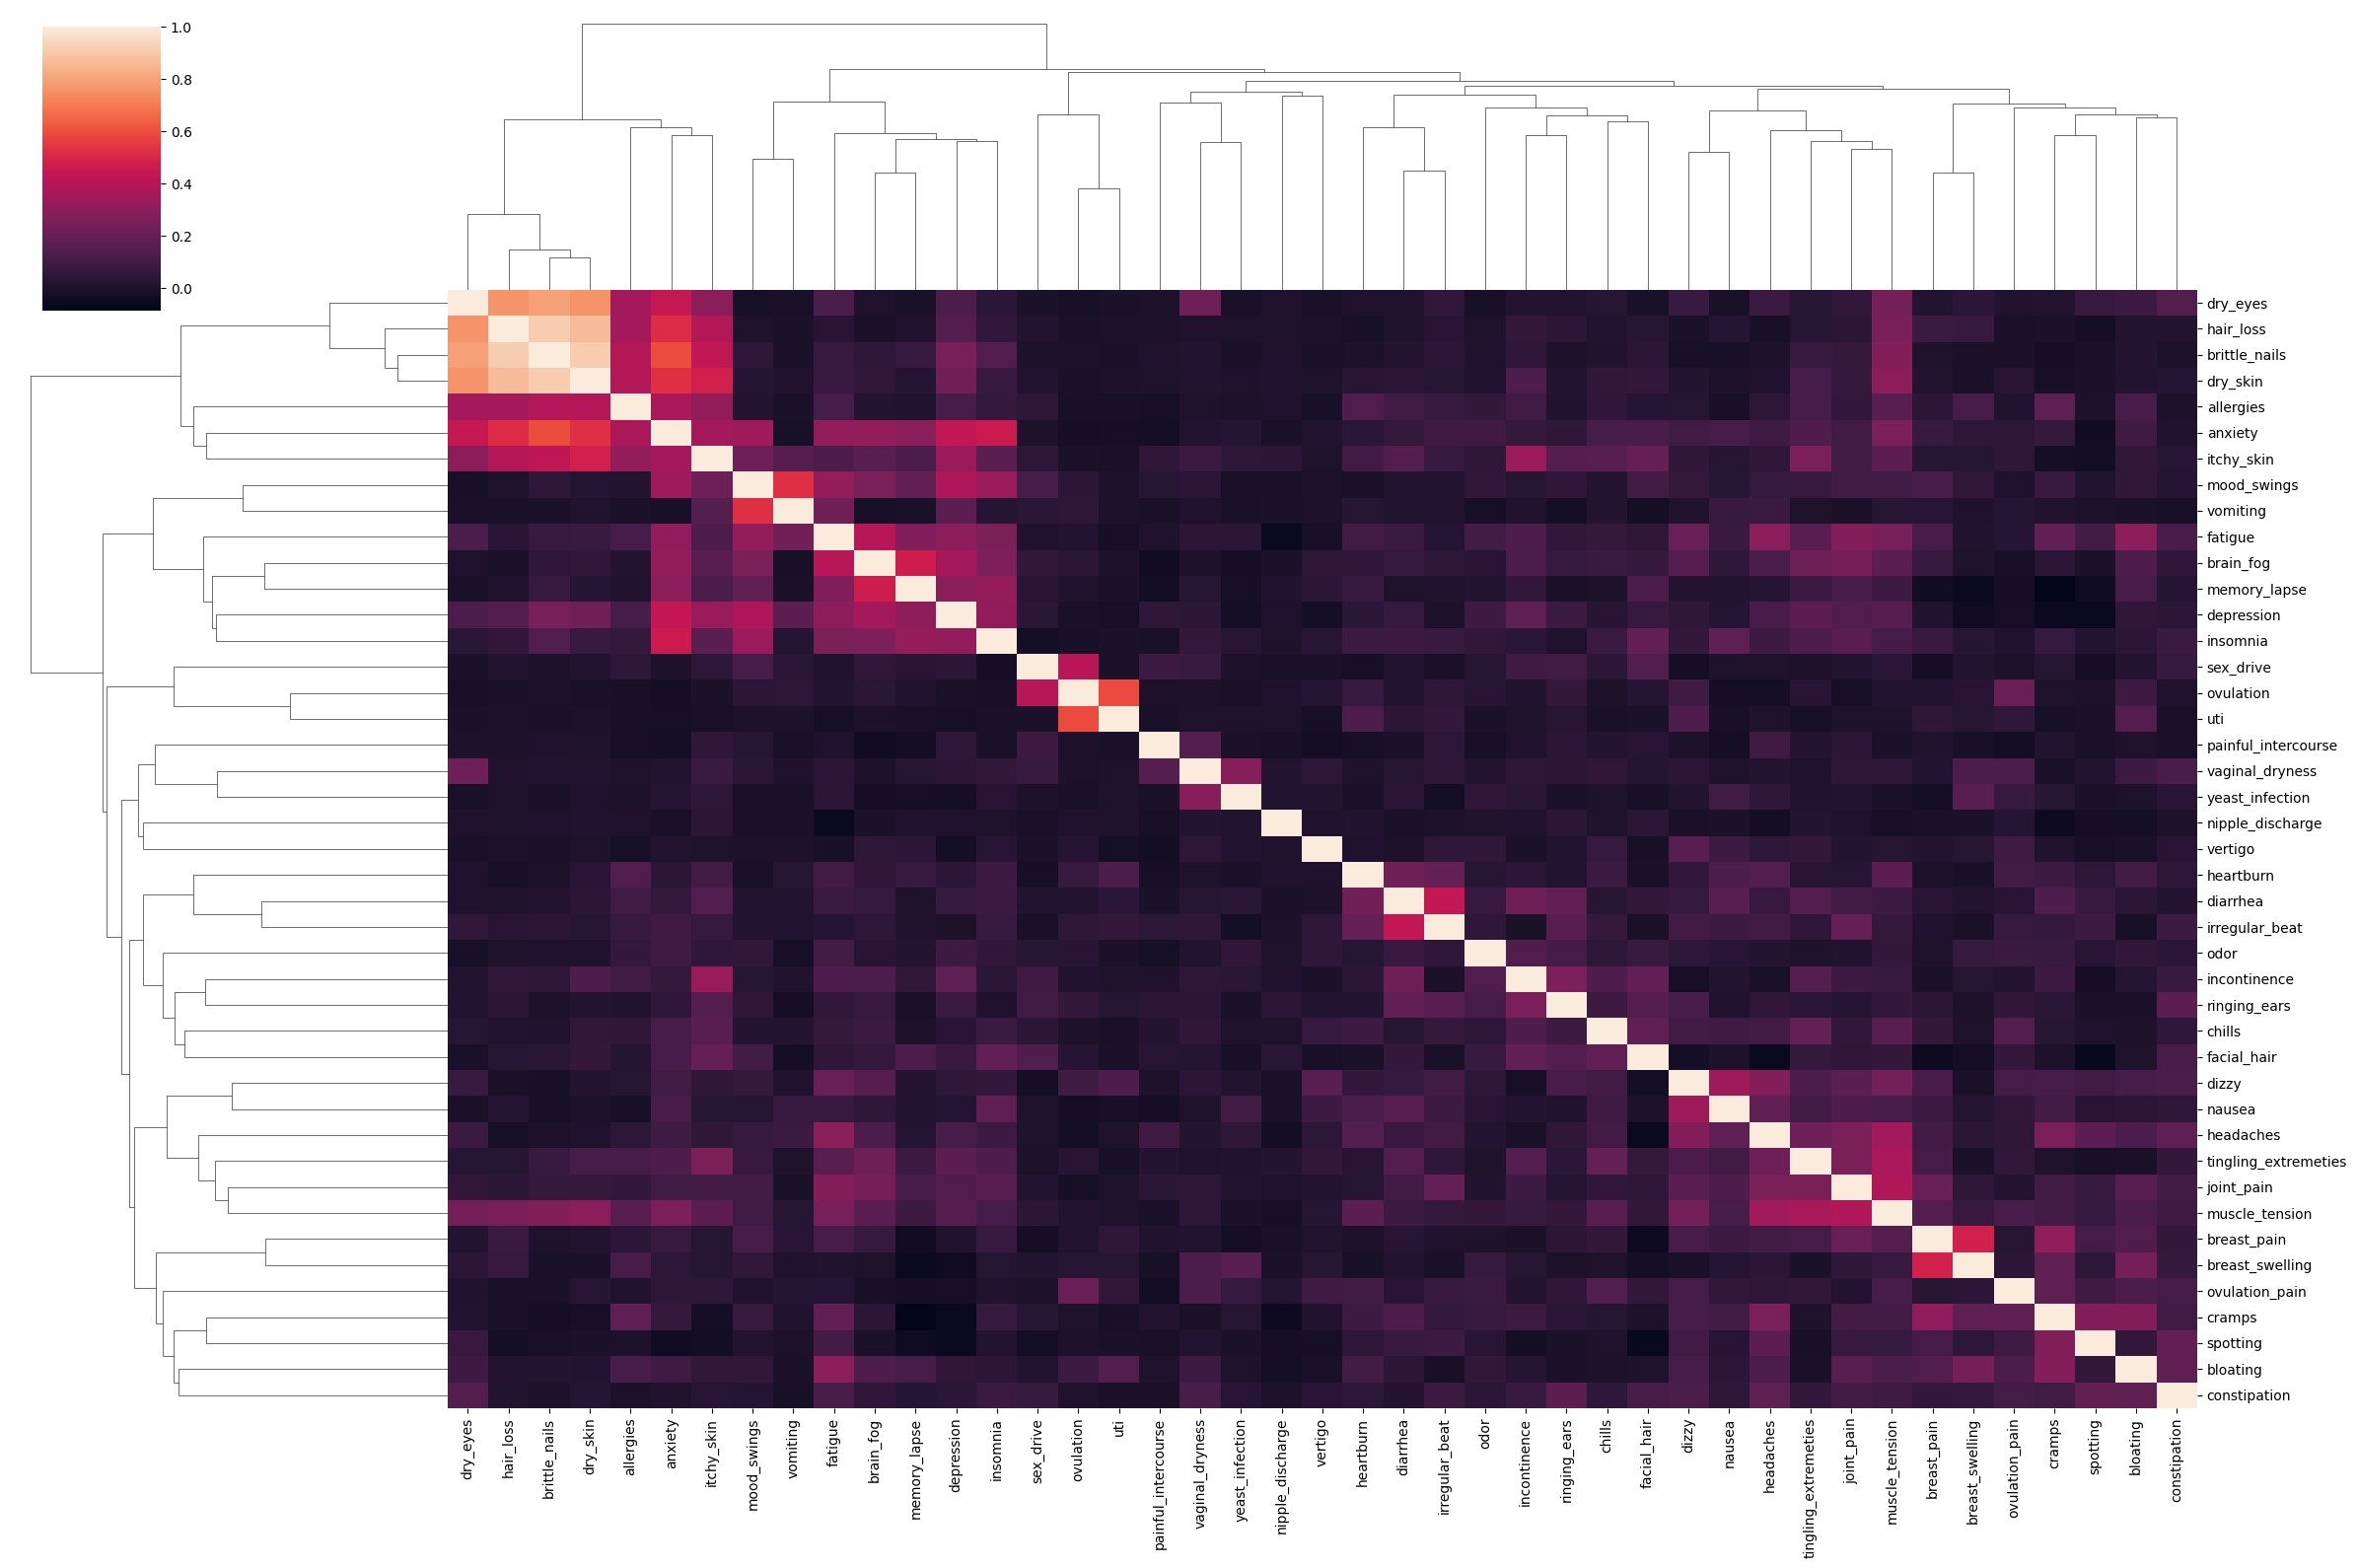

In [42]:
hcluster = sns.clustermap(cmatrix, figsize=(24, 16))

In [50]:
#Note nothing to see from ARI or DBS. We don't have predetermined labels to compare to. 

# Step 1:  extract clustering labels
clustering_labels = hcluster.dendrogram_row.reordered_ind

# Step 2: Calculate ARI for different numbers of clusters (k)
max_clusters = 10  # Choose the maximum number of clusters to evaluate
ari_scores = []

for k in range(2, max_clusters + 1):
    # Replace 'KMeans' with your preferred clustering algorithm (e.g., DBSCAN)
    kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
    predicted_labels = kmeans.fit_predict(cmatrix)
    ari = adjusted_rand_score(clustering_labels, predicted_labels)
    ari_scores.append(ari)
    print(f"ARI for k={k}: {ari:.4f}")

# Step 3: Find the optimal number of clusters based on the ARI scores
optimal_k = ari_scores.index(max(ari_scores)) + 2  # Add 2 to account for k=2 being the starting value

print("Optimal number of clusters:", optimal_k)

# Use the optimal number of clusters for visualization or further analysis
# For example, you can run k-means again with optimal_k and plot the results.

ARI for k=2: 0.0000
ARI for k=3: 0.0000
ARI for k=4: 0.0000
ARI for k=5: 0.0000
ARI for k=6: 0.0000
ARI for k=7: 0.0000
ARI for k=8: 0.0000
ARI for k=9: 0.0000
ARI for k=10: 0.0000
Optimal number of clusters: 2


In [51]:
#Let's use silhouette score instead here. 
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import seaborn as sns

# Get the cluster assignments from the Seaborn plot
cluster_assignments = hcluster.dendrogram_row.reordered_ind

# Convert the cluster assignments to a NumPy array
cluster_assignments = np.array(cluster_assignments)

# Calculate the silhouette scores for different numbers of clusters
max_clusters = 10  # Set a reasonable maximum number of clusters to consider
silhouette_scores = []

for num_clusters in range(2, max_clusters + 1):
    # Perform hierarchical clustering with 'num_clusters'
    cluster_model = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
    cluster_model.fit(cmatrix)
    
    # Calculate the silhouette score for the current number of clusters
    score = silhouette_score(cmatrix, cluster_model.labels_)
    silhouette_scores.append(score)

# Find the optimal number of clusters that maximizes the silhouette score
optimal_num_clusters = np.argmax(silhouette_scores) + 2  # Adding 2 because range starts from 2

print("Optimal number of clusters:", optimal_num_clusters)


Optimal number of clusters: 4


In [ ]:
#Lol, no wonder, clusters are so weak for the premenopausal group! It's basically vague PMS

In [43]:
hcluster.savefig('premeno_iregularnovms_symptom_co_hirach.png')

## Perform PCA analysis on the data.

In [44]:
from sklearn.decomposition import PCA

In [45]:
pca = PCA(n_components=15, svd_solver='full')
X = frame[symptoms]

In [46]:
pca.fit(X)

PCA(n_components=15, svd_solver='full')

In [47]:
evariance = pca.explained_variance_ratio_
cvariance = np.cumsum(evariance)

The variance from the various features is -

In [48]:
for i,v,c in zip(range(1, evariance.size+1), evariance, cvariance):
    print('PCA{} - {:.2f}, {:.2f}'.format(i, v, c))

PCA1 - 0.30, 0.30
PCA2 - 0.28, 0.59
PCA3 - 0.07, 0.66
PCA4 - 0.04, 0.70
PCA5 - 0.03, 0.73
PCA6 - 0.03, 0.76
PCA7 - 0.03, 0.79
PCA8 - 0.02, 0.81
PCA9 - 0.02, 0.83
PCA10 - 0.02, 0.85
PCA11 - 0.01, 0.86
PCA12 - 0.01, 0.88
PCA13 - 0.01, 0.89
PCA14 - 0.01, 0.90
PCA15 - 0.01, 0.91


Looks like we would need 12 principal components if we wanted to keep 90% of the variance. \
However the 2 components account for the majority of variance (64%), while an 80% variance is represented by 7 components.

In [49]:
pcacomponents = pca.fit_transform(X)

In [50]:
pcacomponents.shape

(870, 15)

In [51]:
# Get the impact of each feature on principal component.
impact = pca.components_.T
impact = pd.DataFrame(impact, index=symptoms, columns=pca.get_feature_names_out())

In [52]:
px.imshow(impact, 
          width=512,
          height=700,
          aspect='auto',
          title='Feature impact on principal component')

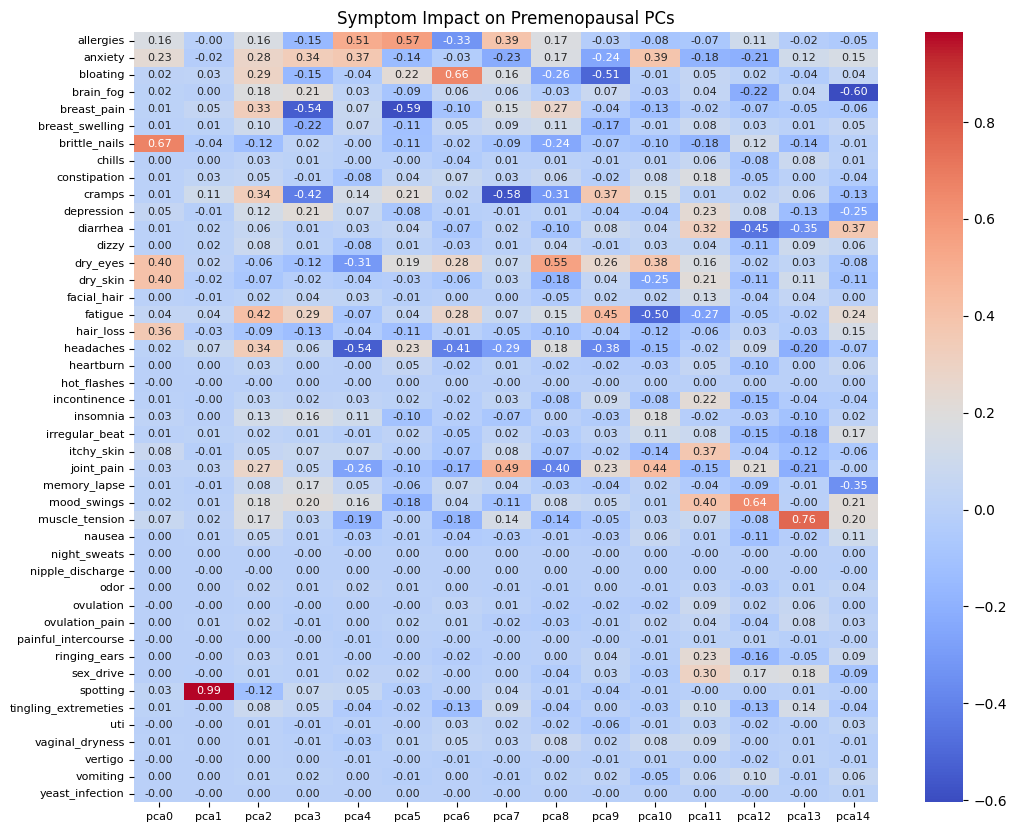

In [53]:
#Alt plot that shows every row label

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have the impact DataFrame 'impact' from your code
# impact = pd.DataFrame(impact, index=symptoms, columns=pca.get_feature_names_out())

# Create a heatmap using seaborn and matplotlib
plt.figure(figsize=(12, 10))
sns.heatmap(impact, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={"size": 8})

# Adjust the font size of x-axis and y-axis tick labels
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Set the title and adjust its font size
plt.title('Symptom Impact on Premenopausal PCs', fontsize=12)

plt.show()

For the clustering we just pick the components that give 90% variance

In [55]:
pca = PCA(n_components=14, svd_solver='full')
pcacomponents = pca.fit_transform(X)
pcacomponents.shape

(870, 14)

In [56]:
from sklearn.cluster import KMeans

## Determining the optimal cluster size.

### Elbow Method

In [57]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    sse.append(kmeans.inertia_)

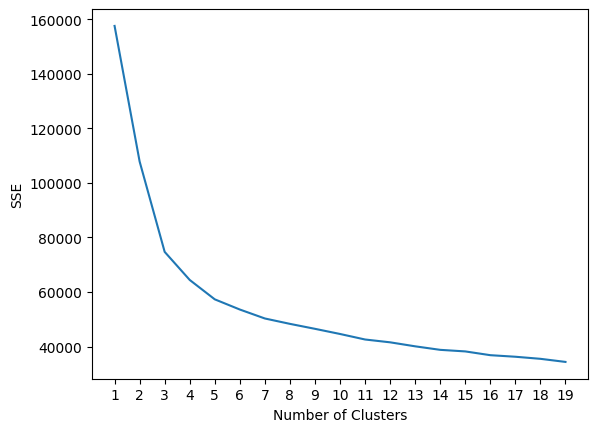

In [58]:
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [59]:
from kneed import KneeLocator

kl = KneeLocator(
    range(1, 20), sse, curve="convex", direction="decreasing"
)

kl.knee

5

Conclusion - Based on the elbow method, it looks like the optimal number of clusters would be **4**

### Silhouette Coefficient

Is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:
* How close the data point is to other points in the cluster
* How far away the data point is from points in other clusters

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

In [60]:
from sklearn.metrics import silhouette_score

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    score = silhouette_score(pcacomponents, kmeans.labels_)
    silhouette_coefficients.append(score)

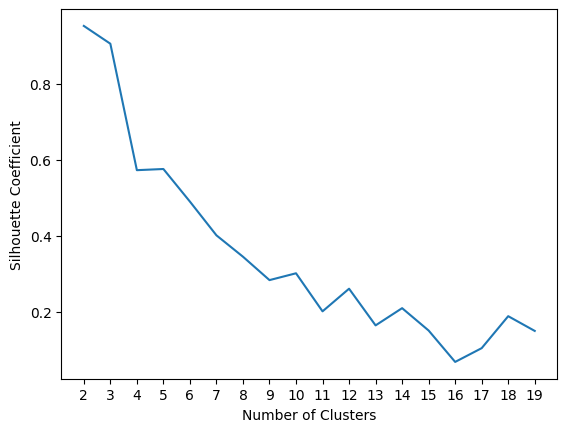

In [61]:
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [62]:
from kneed import KneeLocator

kl = KneeLocator(
    range(1, 20), sse, curve="convex", direction="decreasing"
)

kl.knee

5

Conclusion - From silhouette coeff it looks like the score is maximized for n=3 and then for n=5.
n=3 might be too small of a number of clusters. We will pick n=5 based on the elbow method + S method.

## Cluster them using k-means clustering

In [63]:
kmeans = KMeans(n_clusters=5, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))

0 - 770
1 - 3
2 - 56
3 - 40
4 - 1


## Get the users which belong to each of these clusters

In [64]:
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]

## Find the top 5 symptoms reported by frequency for each of these segments.

In [65]:
def getTopSymptoms(users, top=10):
    # Create the where statement that will be used to filter by these users.
    where_query = "uid = '{}'".format(users[0])
    for i in range(1, len(users)):
        where_query += " or uid = '{}'".format(users[i])
        
    query = """
        select name, count(name) occ from symptoms 
            where {where}
            group by name
            order by occ desc
            limit {top}
    """.format(where=where_query, top=top)
    
    results = db.execQuery(query, cached=True)
    
    return results

In [66]:

## If the block above throws an error - use this. 
def getTopSymptoms(users, top=10):
    if len(users) == 0:
        return pd.DataFrame(columns=['name', 'occ'])  # Return an empty DataFrame if no users in the segment
    
    where_query = "uid IN ('{}')".format("','".join(users))
    
    query = """
        SELECT name, COUNT(name) AS occ FROM symptoms 
        WHERE {where}
        GROUP BY name
        ORDER BY occ DESC
        LIMIT {top}
    """.format(where=where_query, top=top)
    
    results = db.execQuery(query, cached=True)
    return results


In [67]:
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values

In [68]:
for (i,s) in enumerate(segments):
    print('Segment {}'.format(i))
    print(s)

Segment 0
['fatigue' 'bloating' 'cramps' 'anxiety' 'headaches' 'brain_fog'
 'joint_pain' 'spotting' 'allergies' 'breast_pain']
Segment 1
['spotting' 'cramps' 'dry_eyes' 'fatigue' 'headaches' 'constipation'
 'bloating' 'joint_pain' 'breast_pain' 'dizzy']
Segment 2
['fatigue' 'breast_pain' 'bloating' 'anxiety' 'cramps' 'joint_pain'
 'headaches' 'allergies' 'mood_swings' 'muscle_tension']
Segment 3
['spotting' 'cramps' 'breast_pain' 'headaches' 'bloating' 'fatigue'
 'muscle_tension' 'diarrhea' 'mood_swings' 'joint_pain']
Segment 4
['brittle_nails' 'dry_skin' 'dry_eyes' 'hair_loss' 'anxiety' 'allergies'
 'itchy_skin' 'muscle_tension' 'depression' 'fatigue']


Summary of cohort symptoms -

PCA + Clustering was able to isolate the users into 4 clusters based on the occurance of their symptom reporting.a

## Alternatively if we use n=3 for segmentation

In [ ]:
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))
    
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]
    
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values
    
for (i,s) in enumerate(segments):
    print('Segment {}'.format(i))
    print(s)

0 - 5825
1 - 1
2 - 2


InvalidRequestException: An error occurred (InvalidRequestException) when calling the StartQueryExecution operation: 